In [1]:
# Importing requird python packages
# Path to hsmpy package
HSMPY_PATH = r'\\CHCFPP01\Guest\MRajabi\Python Scripts'
import sys, os, arcpy, csv, json, math
sys.path.append(HSMPY_PATH)
import hsmpy3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from IPython.display import Image
from IPython.core.display import HTML 
import subprocess 
import webbrowser
import time
import copy
import shutil
from time import gmtime, strftime
from ipywidgets import FloatProgress
print(strftime("%Y-%m-%d %H:%M:%S"))

2019-01-17 09:10:47


In [2]:
# Defining Parameteres
print(strftime("%Y-%m-%d %H:%M:%S"))
Years = range(2005,2017)
MaxOpenProcesses = 15

Project_DIR  = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO19\HSIP_Tracking_Tool'
Project_GDB  = Project_DIR + '\\2.Project_GDB.gdb'
ContractsDir = Project_DIR + '\\4.Contracts_AnalysisFiles'
DocumentsDir = Project_DIR + '\\5.Documents'
PythonDir    = Project_DIR + '\\6.Python_Codes'
ReceivedDir  = Project_DIR + '\\7.ReceivedData'
XML_Dir      = ReceivedDir + '\\HSIP Candidate Applications'


# IRIS Dataset
IRISPath = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\7_BaseData\Master_BaseFiles_Data\5.0_Roadway_Layer\IRIS'
IRISPath = r'C:\Users\mr068144\Downloads\IL Data\IRIS\IL_IRIS.gdb'
IRIS_Route = {y:os.path.join(IRISPath,'HWY'+str(y)+'_route') for y in Years}
IRIS_Tab   = {y:os.path.join(IRISPath,'HWY'+str(y)+'_table_HCurve') for y in Years}
IRIS_Tab[2012] = IRIS_Tab[2013]

# Intersections Dataset
IntPG = r'C:\Users\mr068144\Downloads\6.0_Intersection_Layer\IRIS_Ints.gdb\Int2014_PG'
Intersections = {year:IntPG for year in Years}

#Crash Dataset
CrashData  = {y:os.path.abspath(r'C:\Users\mr068144\Downloads\IL Data\IL Crash Data\IL_Crash.gdb\\' +
                          'CrashExtract_' + str(y) + '_GIS') for y in Years}

Fields = ['AADT',
          'O_SHD1_TYP','O_SHD1_WTH','O_SHD2_TYP','O_SHD2_WTH',
          'I_SHD1_TYP','I_SHD1_WTH','I_SHD2_TYP','I_SHD2_WTH',
          'LNS','LN_WTH','MED_TYP','MED_WTH','SURF_WTH','URBAN','PG','Radius','CurveLen']
#Fields = ['AADT','URBAN','PG']
RouteID = 'INVENTORY'
BMP = 'BEG_STA'
EMP = 'END_STA'

# Geocoded projects
HSIP_Int  = Project_GDB + '\\WPPS_Int'
HSIP_Seg  = Project_GDB + '\\WPPS_Seg'

HSIP_Path    = ReceivedDir + '\\HSIP_AllApprovedProjects.xlsm'
WPPS_Ob_Path = ReceivedDir + '\\HSIP Contract and Obligation Data.xlsx'
WPPS_Pr_Path = ReceivedDir + '\\HSIP Project Programmed Data.xlsx'
SPF_Data     = ReceivedDir  + '\\SPF Coefficients.xlsx'

2019-01-17 09:10:47


In [3]:
# Reading Input Data
print(strftime("%Y-%m-%d %H:%M:%S"))
XML_DF     = hsmpy3.il.HSIP_DF_From_XML(XML_Dir)

HSIP_DF    = hsmpy3.il.CreateHSIPDataFrame(HSIP_Path,Years)
HSIP_DF = HSIP_DF[[(i in XML_DF.HSIPID) for i in HSIP_DF.index]]

WPPS_Ob_DF = hsmpy3.il.HSIP_DF_WPPS_Ob(WPPS_Ob_Path,HSIP_DF,XML_DF)
WPPS_Pr_DF = hsmpy3.il.HSIP_DF_WPPS_Pr(WPPS_Pr_Path,HSIP_DF,XML_DF)

HSIP_Joined = hsmpy3.il.Joined_HSIP_DF(XML_DF,HSIP_DF,WPPS_Ob_DF,WPPS_Pr_DF)

Cont_DF = hsmpy3.il.Joined_Contract_DF(HSIP_Joined,WPPS_Ob_DF,WPPS_Pr_DF,ReceivedDir,Years)

Loc_DF = hsmpy3.il.Joined_Loc_DF(WPPS_Pr_DF)

SPF_DF = pd.read_excel(SPF_Data,sheetname='Summary')
SPF_DF['PGNumber'] = [int(s.split('PeerGroup ')[1][:2]) for s in SPF_DF.PG]

PN = list(set(Loc_DF['ContNum']))
PN.sort()

Len_DF = pd.DataFrame(Loc_DF.groupby('ContNum')['Length'].aggregate(np.sum))
Cont_DF['Length'] = Len_DF.loc[list(Cont_DF.index),'Length']
print(strftime("%Y-%m-%d %H:%M:%S"))

2018-11-09 10:19:06
2018-11-09 10:23:29


In [3]:
XML_DF = pd.read_excel(DocumentsDir+'\\XML_DF.xlsx')
XML_DF.index = XML_DF.HSIPID.astype(int)
Cont_DF = pd.read_excel(DocumentsDir+'\\Cont_DF.xlsx',index_col=0)
HSIP_DF = pd.read_excel(DocumentsDir+'\\HSIP_DF.xlsx')
HSIP_DF.index = HSIP_DF['HSIP ID'].astype(int)
HSIP_Joined = pd.read_excel(DocumentsDir+'\\HSIP_Joined.xlsx')
HSIP_Joined.index = HSIP_Joined.HSIPID.astype(int)
BC_DF = pd.read_excel(r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO19\HSIP_Tracking_Tool\9.QC_Milhouse\QC_Contracts_FromKyle.xlsx',index_col=0)
CMF_DF = pd.read_excel(r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO19\HSIP_Tracking_Tool\9.QC_Milhouse\ServiceLife.xlsx',index_col=1,skiprows=3)

In [93]:
L = []
for i in HSIP_Joined.AllSelectedImprovements:
    L.extend(i.split(';'))
L = pd.Series(L)
HTML(pd.DataFrame(L.value_counts()).to_html())
pd.DataFrame(L.value_counts()).to_excel('Treatments_List.xlsx')

In [92]:
keywords = ['shoulder','rumble','guardrail','cable','relocation','curve','marking','flatten','sign','pedestrian','median','lane',
            'lighting','delineator','chevron','sidewalk','visibility','roadside','clear zone',
            'mast arms','signal','realignment','left','channelization','right','warning','sight distance','flashing','roundabout','lens',
            'resurfacing','deslick',
            'attenuators'
           ]
for kw in keywords:
    l1 = []
    for l in L:
        if kw in l.lower():
            l1.append(l)
    display(pd.DataFrame(pd.Series(l1).value_counts(),columns=[kw]))

shoulder
Add or Widen Paved Shoulder                               73
Increase Width of Paved Shoulder                          65
Shoulder rumble strips and stripes                        34
Modify Shoulder Type                                      20
Install milled-in rumble strips to both shoulde...         9

rumble
Rumble strips                                           82
Shoulder rumble strips and stripes                      34
Centerline rumble strips and stripes                    23
Rumble Strips (Transverse)                              20
Install milled-in rumble strips to both shoulde...       9
Rumble stripes                                           6
Install centerline milled rumble strips on a ma...       1
Apply rumble strips at unsignalized stop approa...       1

guardrail
Guardrail                                                 131
Traffic barriers (guardrail, median barriers, b...         16
Install only new guardrail end sections that pa...         10
Other ImprovementGuardrail                                  1

cable
Install Cable Median Barrier (All Crashes)             22
Installation of cable median barrier and Nucor ...      8
Install Cable Median Barrier (Crash Specific)           3

relocation
Fixed object removal and relocation          18
Relocation of Signal Supports                 4

curve
Improve Superelevation on Curve                        13
Install Chevron Signs on Horizontal Curves             11
Install Advanced Curve Speed/Warning Sign               8
Modify Horizontal Curve Radius and Length w/o S...      4

marking
Raised pavement markings                                 11
Improve pedestrian signing and pavement markings.        10
Place Edgeline and Centerline Markings                   10
Innovative pavement marking and signing                   8
Enhance and/or innovative traffic control devic...        5
Place Standard Edgeling Markings                          3
Place Centerline Markings                                 2
Provide "Stop Ahead" Pavement Markings                    2
All-weather pavement markings                             2
3-D tape pavement marking                                 1
Wide pavement markings                                    1

flatten
Flattened slopes       11

sign
Add Mast Arms and Signal Head per Lane                82
LED signals                                           70
Install Traffic Signals                               70
Countdown pedestrian crosswalk signals                41
Upgrade Signs to conform with MUTCD                   33
Traffic Signal Modernization                          24
Implement offset left turns at signalized inter...    18
Install Advance Signal Warning Signs                  16
Use alternative designs, such a roundabouts, fo...    12
Install Chevron Signs on Horizontal Curves            11
Improve pedestrian signing and pavement markings.     10
Speed Signing                                         10
Innovative pavement marking and signing                8
Install Advanced Curve Speed/Warning Sign              8
Enhance and/or innovative traffic control devic...     5
Relocation of Signal Supports                          4
Install Advance Signal Warning with Flashers           4
Directional signs                                      4
Alignments meeting minimum design speeds               4
Install Advance Street Name Signs                      3
Pursue more easily read sign fonts such as Clea...     3
Other ImprovementAdd Mast Arms and Signal Head ...     2
Install illuminated street signs.                      2
Interconnected signals                                 2
Other ImprovementChangeable Message Signs              1
Yield Sign                                             1
Apply rumble strips at unsignalized stop approa...     1

pedestrian
Countdown pedestrian crosswalk signals                     41
Improve pedestrian signing and pavement markings.          10
Add Pedestrian Controls                                    10

median
Install Cable Median Barrier (All Crashes)              22
Traffic barriers (guardrail, median barriers, b...      16
Install Median Barrier (General)                         9
Installation of cable median barrier and Nucor ...       8
Provide  a Raised Median                                 5
Raised Reflective Marker Median                          4
Install Cable Median Barrier (Crash Specific)            3
Change Width of Existing Median (with Partial/N...       2
New median barrier devices and installations             2

lane
Add Mast Arms and Signal Head per Lane                82
Exclusive left-turn lanes                             48
Add Right Turn Lane on One Approach                   19
Add Left Turn Lane (ThreeLeg Intersection)            12
Lane Addition                                          9
Modify Lane Width                                      5
Other ImprovementAdd Mast Arms and Signal Head ...     2
Increase Lane Width                                    2
Left Turn Acceleration Lane                            2
Other ImprovementModify Lane Width                     1
Remove Through Lane (Road Diet  Large Urban Area)      1
Add Lanes by Narrowing Existing Lanes                  1

lighting
Roadway lighting                                  14
Enhance roadway lighting                           7
Increase lighting at high-crash locations.         6
Safety Lighting                                    6
Provide Lighting                                   1

delineator
Chevrons or delineators                                     23
Install Post Mounted Delineators                             6
Delineators                                                  5
Install Edgelines, Centerlines and Post Mounted...           3

chevron
Chevrons or delineators                          23
Install Chevron Signs on Horizontal Curves       11

sidewalk
Include additional sidewalks in roadway improve...         6

visibility
Expand and maintain roadway visibility features.           3

roadside
Reduce Roadside Hazard Rating                  3
Increase Distance to Roadside Features         1

clear zone
Adequate clear zones           2

mast arms
Add Mast Arms and Signal Head per Lane                     82
Other ImprovementAdd Mast Arms and Signal Head ...          2

signal
Add Mast Arms and Signal Head per Lane                  82
LED signals                                             70
Install Traffic Signals                                 70
Countdown pedestrian crosswalk signals                  41
Traffic Signal Modernization                            24
Implement offset left turns at signalized inter...      18
Install Advance Signal Warning Signs                    16
Enhance and/or innovative traffic control devic...       5
Install Advance Signal Warning with Flashers             4
Relocation of Signal Supports                            4
Interconnected signals                                   2
Other ImprovementAdd Mast Arms and Signal Head ...       2
Apply rumble strips at unsignalized stop approa...       1

realignment
Improvement/Realignment/Reconstruction                       93
Other ImprovementImprovement/Realignment/Recons...            3

left
Exclusive left-turn lanes                             48
Add Left Turn Phase on One Approach (Permissive...    21
Implementation of protected left-turn phasing a...    18
Implement offset left turns at signalized inter...    18
Add Left Turn Phase on One Approach (Permissive...    13
Add Left Turn Lane (ThreeLeg Intersection)            12
Modify permissive left-turn phasing to protect ...     9
Left Turn Acceleration Lane                            2
Other ImprovementAdd Left Turn Phase on One App...     1
Other ImprovementImplementation of protected le...     1

channelization
Improve roadway geometrics and channelization              19

right
Add Right Turn Lane on One Approach     19

warning
Advance Warning with Flasher                       18
Install Advance Signal Warning Signs               16
Install Advanced Curve Speed/Warning Sign           8
Install Advance Signal Warning with Flashers        4

sight distance
Improve sight distance at intersection approaches.              15
Other ImprovementImprove sight distance at inte...               1

flashing
Flashing Beacon                            13
Implement dynamic flashing beacons.         5

roundabout
Use alternative designs, such a roundabouts, fo...          12
Convert AllWay Stop Controlled Intersection to ...           1
Convert StopControlled Intersection to Roundabout            1

lens
Increase to 12 Inch Lens     5

resurfacing
Resurfacing alone                                            22
Widening and Resurfacing or Widening alone                   21
Other ImprovementWidening and Resurfacing or Wi...            1
Other ImprovementResurfacing alone                            1

deslick
DeSlick (formerly known as skidproofing)       27

attenuators
Impact Attenuators                            27
Other ImprovementImpact Attenuators            1

In [4]:
BC_DF['ContNum'] = BC_DF.index
pd.DataFrame(BC_DF[BC_DF['Has BC Summary Sheet in the attachments? (Yes,No)']=='Yes'].groupby(['ContNum','HSIPIDs','Has BC Summary Sheet in the attachments? (Yes,No)','Major Countermeasure (If there was no BC Summary Sheet)']).size())

0
ContNum HSIPIDs             Has BC Summary Sheet in the attachments? (Yes,No) Major Countermeasure (If there was no BC Summar...   
60D32   201410003           Yes                                               Cablerail Installation                              1
60F62   201410030           Yes                                               Install Traffic Signals                             1
60F77   201410042           Yes                                               Guardrail End Replacement                           1
                                                                              Impact Attenuators                                  1
                                                                              Rumble Strips (Shoulder, w/o FO Crashes)            1
60F81   201410035           Yes                                               Countdown Pedestrian Signals                        1
                                                                              General Pavement Markings                           1
60F87   201410038           Yes                                               Add Mast Arms and Signal Head per Lane              6
                                                                              Improvement/Reallignment/Reconstruction URBAN       1
                                                                              Provide Lighting                                    2
                                                                              ROW Acquisition                                     1
60G40   201410039           Yes                                               Modernization                                       1
60H72   201410046           Yes                                               Advance Warning with Flasher                        1
                                                                              Chevrons or Delineators                             1
                                                                              General/Fixed Obstacle Removal                      1
                                                                              Rumble Strips (Shoulder)                            1
                                                                              Shoulder Improvement                                1
60P20   201410292           Yes                                               Reallignment/Reconstruction URBAN                   1
                                                                              Sign Modernization                                  1
60P90   201410276           Yes                                               Improvement/Reallignment/Reconstruction URBAN       1
                                                                              Modernization                                       2
                                                                              Phase Adjustment                                    1
60R59   201302003           Yes                                               Channelization                                      1
60T88   201310023           Yes                                               Improvement/Reallignment/Reconstruction URBAN       1
                                                                              Modernization                                       1
                                                                              Resurfacing Alone                                   1
60T95   201310020           Yes                                               Improvement/Reallignment/Reconstruction URBAN       1
60T98   201212014           Yes                                               Add Mast Arms and Signal Head per Lane              2
60V59   201212021           Yes                                               Add Mast Arms and Signal Head per Lane              1
                                      

In [5]:
list(BC_DF)

District              HSIPIDs LastLettingDate  AwardDate  \
60A25       1.0            201407016      2007-06-15 2007-07-18   
60C09       1.0            201407009      2007-04-27 2007-05-21   
60C14       1.0            201407014      2007-06-15 2007-07-18   
60C15       1.0            201407019      2007-06-15 2007-07-30   
60D20       1.0            201410006      2008-01-18 2008-02-15   
60D20       NaN            201410006             NaT        NaT   
60D32       1.0            201410003      2008-04-25 2008-05-16   
60D33       1.0            201410004      2008-01-18 2008-02-19   
60D34       1.0            201410005      2008-03-07 2008-03-28   
60D34       NaN            201410005             NaT        NaT   
60D34       NaN            201410005             NaT        NaT   
60D37       1.0            201410016      2008-03-07 2008-04-03   
60D37       NaN            201410016             NaT        NaT   
60D37       NaN            201410016             NaT        NaT   
60D37       NaN            201410016             NaT        NaT   
60D38       1.0            201410017      2008-03-07 2008-04-03   
60D38       NaN            201410017             NaT        NaT   
60D38       NaN            201410017             NaT        NaT   
60D39       1.0            201410015      2008-04-25 2008-05-20   
60D39       NaN            201410015             NaT        NaT   
60D39       NaN            201410015             NaT        NaT   
60D39       NaN            201410015             NaT        NaT   
60D40       1.0            201410014      2008-03-07 2008-04-03   
60D43       1.0            201407021      2008-04-25 2008-05-20   
60D43       NaN            201407021             NaT        NaT   
60D43       NaN            201407021             NaT        NaT   
60D51       1.0            201407015      2008-01-18 2008-02-21   
60D51       NaN            201407015             NaT        NaT   
60D54       1.0            201410012      2008-03-07 2008-04-10   
60D98       1.0            201410019      2008-03-07 2008-04-03   
...         ...                  ...             ...        ...   
97462       NaN            201506024             NaT        NaT   
97462       NaN            201506024             NaT        NaT   
97519       8.0            201211010      2013-06-14 2013-07-09   
97519       NaN            201211010             NaT        NaT   
97542       8.0            201211005      2014-01-17 2014-02-24   
99283       9.0            201410235      2007-01-19 2007-02-14   
99293       9.0            201410234      2007-06-15 2007-07-18   
99306       9.0            201506015      2007-11-16 2008-01-04   
99326       9.0            201506016      2008-08-01 2008-08-22   
99326       NaN            201506016             NaT        NaT   
99326       NaN            201506016             NaT        NaT   
99366       9.0            201506018      2009-06-12 2009-07-15   
99366       NaN            201506018             NaT        NaT   
99366       NaN            201506018             NaT        NaT   
99369       9.0            201506017      2009-06-12 2009-07-15   
99369       NaN            201506017             NaT        NaT   
99369       NaN            201506017             NaT        NaT   
99369       NaN            201506017             NaT        NaT   
99413       9.0            201507013      2010-01-15 2010-02-11   
99413       NaN            201507013             NaT        NaT   
99413       NaN            201507013             NaT        NaT   
99443       9.0  201507013;201507014      2011-01-21 2011-02-15   
99443       NaN  201507013;201507014             NaT        NaT   
99443       NaN  201507013;201507014             NaT        NaT   
99463       9.0            201507015      2011-11-18 2011-12-08   
99463       NaN            201507015             NaT        NaT   
99495       9.0            201212015      2013-03-08 2013-04-17   
99495       NaN            201212015             NaT  

In [59]:
BC_DF['Major Countermeasure (If there was no BC Summary Sheet)'].value_counts()

2.1.9.S1.1 - Pavement Treatments - Install Rumble Strips (Shoulder)                                          46
1.4.1.I1.1 - Signalization - Install Traffic Signals                                                         35
4.7.2.S1.1 - Roadside Safety - Install w-beam guardrail                                                      31
2.1.3.S1.1 - Pavement Treatments - Add or Widen Paved Shoulder                                               17
Rumble Strips (Centerline)                                                                                   15
Install Rumble Strips (Shoulder)                                                                             14
Cannot determine what improvements were made                                                                 14
1.4.26.I7.1 - Signalization - Replace Incandescent Traffic Signal Bulbs with Light Emitting Diodes (LEDs)    14
Add Mast Arms and Signal Head per Lane                                                                  

In [13]:
#for ContNum in set(Cont_DF.ContNum):
ContNum = "61A64"
for i in [1]:
    if not ContNum in Cont_DF.index:
        continue
    hsips = list(set(Cont_DF[Cont_DF.index.isin([ContNum])]['HSIPIDs']))[0]
    print(ContNum,hsips)
    for hsipid in hsips.split(';'):
        
        print(XML_DF.loc[int(hsipid),'ProblemDescription'])
        print(XML_DF.loc[int(hsipid),'ProposedImprovementsDescription'])
        #print('Has BC Summary Sheet in the attachments? ',BC_DF.loc[ContNum,'Has BC Summary Sheet in the attachments? (Yes,No)'])
        #print(BC_DF.loc[ContNum,'Major Countermeasure (If there was no BC Summary Sheet)'],' : ',
        #CMF_DF.loc[BC_DF.loc[ContNum,'Major Countermeasure (If there was no BC Summary Sheet)'],'CMF'],
        #CMF_DF.loc[BC_DF.loc[ContNum,'Major Countermeasure (If there was no BC Summary Sheet)'],'Crash Type Affected by Countermeasures'])
    
#display(HTML(pd.DataFrame(BC_DF.loc[ContNum]).to_html()))
#for hsipid in BC_DF.loc[ContNum,'HSIPIDs'].split(';'):
#    display(HTML(pd.DataFrame(HSIP_Joined.loc[int(hsipid)]).to_html()))
#    display(HTML(pd.DataFrame(XML_DF.loc[int(hsipid)]).to_html()))

61A64 201212028;201310027
High amount of rear-end and turning accidents along 75th St. at the intersection with Plainfield-Naperville Rd/Rickert Dr. including 8 A-injury and 22 B-injury accidents, which could be attributed to high volume of traffic and high speeds on 75th St., an SRA.
Construct RTLs on both 75th St. approaches, reduce median on both 75th St. approaches to accommodate dual LTLs, update traffic signals to accommodate movements from new RTLs and dual LTLs along 75th St.
High amount of turning accidents along 75th Street, a Stretegic Regional Arterial, can be attributed to high volume of traffic and speeds on 75th street. High amount of rear-end accidents along southbound Book Road, can be attributed to high P.M. peak hour volumes and insufficient capacity. Location of trail crossing to intersection makes it difficult for turning vehicles to see trail users.
Modernize left turn traffic signals on 75th Street from protected/permitted to protected only, lengthen left turn la

In [4]:
Int = hsmpy3.common.FCtoDF(HSIP_Int)
Seg = hsmpy3.common.FCtoDF(HSIP_Seg)
Seg['Mileage'] = Seg.Shape_Length/5280.0
df = pd.DataFrame()
l = []
for cont in Cont_DF.index:
    for hsip in Cont_DF.loc[cont,'HSIPIDs'].split(';'):
        l.append((cont,hsip))
df['ContNum'] = [i[0] for i in l]
df['HSIPID']  = [i[1] for i in l]
df.index = pd.MultiIndex.from_tuples(l,names=['ContNum','HSIPID'])
df['ProblemDesc'] = list(XML_DF.ProblemDescription.loc[list(df.HSIPID.astype(int))])
df['ImproveDesc'] = list(XML_DF.ProposedImprovementsDescription.loc[list(df.HSIPID.astype(int))])
df['Improvements'] = list(HSIP_Joined.AllSelectedImprovements.loc[list(df.HSIPID.astype(int))])
df['Mileage'] = list(Seg.groupby('ContNum')['Mileage'].aggregate(sum).loc[list(df.ContNum)])
df['NumInt'] = list(Int.groupby('ContNum').size().loc[list(df.ContNum)])
df['HasPlans'] = list(pd.Series(index=os.listdir(ReceivedDir + '\\Plans'),data=1).loc[list(df.ContNum)])
df['Status'] = list(Cont_DF.Status.loc[list(df.ContNum)])
df['AwardDate'] = list(Cont_DF.F_AwardDate.loc[list(df.ContNum)])
df['CompDate']  = list(Cont_DF.F_CompDate.loc[list(df.ContNum)])
df['BeforePeriod']  = list(Cont_DF.BeforePeriod.loc[list(df.ContNum)])
df['AfterPeriod']   = list(Cont_DF.AfterPeriod.loc[list(df.ContNum)])
df.NumInt = df.NumInt.fillna(0)
df.Mileage = df.Mileage.fillna(0)
df.HasPlans = df.HasPlans.fillna(0)
df['Geocoded'] = [{True:1,False:0}[(i>0 or m>0)] for i,m in zip(df.Mileage,df.NumInt)]
df = df[(df.AwardDate>datetime(2007,1,1,0,0)) & 
        (df.CompDate<=datetime(2015,1,1,0,0)) & 
        (df.Status=='C') & 
        ((df.Geocoded==1) | (df.HasPlans==1))
       ]
df['TargetCrashs'] = list(HSIP_Joined.TargetCrashType.loc[list(df.HSIPID.astype(int))])
df['CompAmount'] = list(Cont_DF.CompletionAmount.loc[list(df.ContNum)])
df['HSIPAmount'] = list(Cont_DF.HSIPAmount.loc[list(df.ContNum)])
df['ServiceLife'] = list(Cont_DF.ServiceLife.loc[list(df.ContNum)])
#df.to_excel('PlansDataCollection.xlsx')

In [9]:
Cont_DF.IsSystemic.loc[list(set(df.ContNum))].value_counts()

False    289
True      98
Name: IsSystemic, dtype: int64

In [10]:
df.Geocoded.value_counts()

1    354
0     47
Name: Geocoded, dtype: int64

In [42]:
for i in df.index:
    if i[0] in BC_DF.index:
        n = BC_DF[BC_DF.index==i[0]].shape[0]
    else:
        print(i,0)

('64L78', '201610002') 0
('85648', '201701002') 0
('74749', '201304008') 0
('70A56', '201602003') 0
('74750', '201608003') 0
('78519', '201606002') 0
('78519', '201606003') 0
('78519', '201606004') 0
('62A67', '201502012') 0
('62A67', '201503003') 0
('85615', '201506058') 0
('64J35', '201311001') 0
('68C67', '201502006') 0
('60T97', '201203004') 0
('62B22', '201602002') 0
('66F16', '201607004') 0
('64L20', '201512002') 0
('74748', '201305005') 0
('91531', '201412002') 0
('64L33', '201607003') 0
('66F29', '201609001') 0
('64L32', '201607002') 0
('62C12', '201608001') 0
('70B73', '201607008') 0
('66905', '201208001') 0
('70B69', '201606001') 0
('60W54', '201410297') 0
('66F18', '201607006') 0
('66F17', '201607005') 0
('78476', '201604001') 0
('66F04', '201605007') 0
('63862', '201507007') 0
('63862', '201507008') 0
('66F05', '201605009') 0
('89656', '201310018') 0
('74742', '201502005') 0
('64L29', '201601001') 0
('74713', '201501003') 0
('66F06', '201605010') 0
('72G75', '201506022') 0


('93477', '201410167') 1
('93477', '201505034') 1
('99369', '201506017') 4
('64E55', '201410401') 1
('76D04', '201410376') 1
('66779', '201410106') 2
('89480', '201410117') 2
('76D14', '201410386') 5
('76C31', '201410218') 1
('64E90', '201410313') 1
('60F81', '201410035') 2
('93479', '201506029') 1
('60F54', '201410028') 1
('60F74', '201410037') 2
('60F77', '201410042') 3
('76C14', '201410217') 1
('76B22', '201410208') 0
('68110', '201410113') 1
('76B57', '201410213') 1
('76A76', '201410216') 1
('60F73', '201407007') 1
('76C32', '201410221') 2
('64E50', '201410081') 3
('76C30', '201410219') 1
('64D51', '201410078') 2
('60D32', '201410003') 1
('76C29', '201410220') 1
('63048', '201407024') 1
('60F76', '201410036') 1
('99326', '201506016') 3
('64E51', '201410082') 2
('60D54', '201410012') 1
('97323', '201506021') 2
('76B48', '201410212') 1
('66768', '201410104') 1
('68768', '201410115') 3
('72B93', '201410346') 0
('60D98', '201410019') 1
('62949', '201203013') 4
('62949', '201410010') 4


('LAVD102', '201502013') 0
('LAVD104A', '201212010') 0
('LAVD104A', '201305004') 0
('LAVD104B', '201410256') 0
('PSD3581370', '201512003') 0
('UT207002', '201410059') 0
('UT814051', '201301001') 0
('UT814052', '201301001') 0
('UT818001', '201611005') 0
('UT818002', '201611005') 0


In [5]:
#Aggregated Results
print(strftime("%Y-%m-%d %H:%M:%S"))
for per in ['Before','After']:
    for sev in ['K','A','B']:
        for met in ['OC','EC']:
            Cont_DF['_'.join([per[0],sev,met])] = 0.0
Cont_DF['EUAC'] = 0.0
Cont_DF['EUAB_OC'] = 0.0
Cont_DF['EUAB_EC'] = 0.0
Cont_DF['BC_OC'] = 0.0
Cont_DF['BC_EC'] = 0.0
XLSPath = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO19\HSIP_Tracking_Tool\4.Contracts_AnalysisFiles'
XLSList = [os.path.join(XLSPath, f) for f in os.listdir(XLSPath) if os.path.isfile(os.path.join(XLSPath, f)) and f.split('.')[1]=='xlsx' and 'HSIP_' in f.split('.')[0]]
f = FloatProgress(min=0, max=len(XLSList))
display(f)
for xls in XLSList:
    p = str(os.path.basename(xls).split('_')[1].split('.')[0])
    df10 = pd.read_excel(xls,'BCSummary')
    df10.index = df10.Period
    #display(df10)
    for per in ['Before','After']:
        for sev in ['K','A','B']:
            for met in ['OC','EC']:
                try:
                    Cont_DF.set_value(p,'_'.join([per[0],sev,met]),df10.loc[per]['_'.join([sev,met])].item())
                except:pass
    for c in ['EUAC','EUAB_OC','EUAB_EC','BC_OC','BC_EC']:
        try:
            Cont_DF.set_value(p,c,df10.loc['After'][c].item())
        except:pass
    f.value += 1
Cont_DF.to_excel(Project_DIR+'\\5.Documents\\Cont_DF_Sorted1.xlsx')
print(strftime("%Y-%m-%d %H:%M:%S"))

2018-09-11 14:32:53


FloatProgress(value=0.0, max=328.0)

2018-09-11 14:37:35


In [6]:
#Adding Joined Contracts and Applications
print(strftime("%Y-%m-%d %H:%M:%S"))
HSIP_Joined['NumOfCont'] = [len(s.split(';')) for s in HSIP_Joined.ContNums]
Cont_DF['NumOfHSIP'] = [len(str(s).split(';')) for s in Cont_DF.HSIPIDs]
NumOfJoinedCont = []
NumOfCompJoinedCont = []
for i,r in Cont_DF.iterrows():
    cont_l = []
    hsip_ids = str(r.HSIPIDs).split(';')
    for hsip in hsip_ids:
        cont_l.extend(HSIP_Joined.loc[hsip]['ContNums'].split(';'))
        cont_l.extend(HSIP_Joined.loc[hsip]['ContNums'].split(';'))
        s = ''
        for cont in HSIP_Joined.loc[hsip]['ContNums'].split(';'):
            cont_l.extend(HSIP_Joined.loc[hsip]['ContNums'].split(';'))
    cont_l = list(set(cont_l))
    NumOfJoinedCont.append(';'.join(cont_l))
Cont_DF['Joined_Conts'] = NumOfJoinedCont
Cont_DF['HSIPAmount'] = [sum([r[c] for c in ['D20','D21','D28','D10','D15','D22']]) for i,r in Cont_DF.iterrows()]
Cont_DF['NumOfJoinedConts'] = [len(s.split(';')) for s in Cont_DF.Joined_Conts]

HSIP_Seg = hsmpy3.common.AttributeTabletoDF(Project_GDB+'\\HSIP_Seg',True)
HSIP_Int = hsmpy3.common.AttributeTabletoDF(Project_GDB+'\\HSIP_Int')
HSIP_Seg['Mileage'] = [s.length/5280.0 for s in HSIP_Seg.Shape]
HSIP_Seg_Leng = []
HSIP_Int_Count = []
for i,r in Cont_DF.iterrows():
    hsip_ids = str(r.HSIPIDs).split(';')
    tot_l = []
    tot_c = []
    for hsip in hsip_ids:
        tot_l.append(sum(list(HSIP_Seg[HSIP_Seg.HSIPID == hsip]['Mileage'])))
        tot_c.append(len(list(HSIP_Int[HSIP_Int.HSIPID == hsip]['HSIPID'])))
    HSIP_Int_Count.append(sum(tot_c))
    HSIP_Seg_Leng.append(sum(tot_l))
Cont_DF['HSIP_Seg_Len'] = HSIP_Seg_Leng
Cont_DF['HSIP_Int_Count'] = HSIP_Int_Count

HSIP_AwDate = []
HSIP_CmDate = []

for i,r in Cont_DF.iterrows():
    hsip_ids = str(r.HSIPIDs).split(';')
    tot_l = []
    tot_c = []
    for hsip in hsip_ids:
        if int(hsip) in list(HSIP_DF.index):
            tot_l.append(HSIP_DF['Award Date'][int(hsip)])
            tot_c.append(HSIP_DF['Completion Date'][int(hsip)])
    tot_l = list(set([d for d in tot_l if not pd.isnull(d)]))
    tot_c = list(set([d for d in tot_c if not pd.isnull(d)]))
    if tot_l!=[]:
        HSIP_AwDate.append(max(tot_l))
    else:
        HSIP_AwDate.append(max([None]))
    if tot_c!=[]:
        HSIP_CmDate.append(min(tot_c))
    else:
        HSIP_CmDate.append(max([None]))
Cont_DF['HSIP_AwardDate'] = HSIP_AwDate
Cont_DF['HSIP_CompDate'] = HSIP_CmDate

2018-09-11 14:37:35


In [146]:
#Adding Descriptions to HSIP Table
print(strftime("%Y-%m-%d %H:%M:%S"))
QC_HSIP = Project_DIR + '\\8.Data_Collection_EFK\QC_GDB.gdb\HSIP_Applications'
arcpy.management.GetCount(QC_HSIP)
uc = arcpy.UpdateCursor(QC_HSIP)
for row in uc:
    hsip = row.getValue('HSIPID')
    s = str(XML_DF.LocationDescription[int(hsip)])
    if len(s)>900: 
        s = s[:900]
    row.setValue('LocDesc',s)

    s = str(XML_DF.ProblemDescription[int(hsip)])
    if len(s)>900: 
        s = s[:900]
    row.setValue('ProblemDesc',s)

    s = str(XML_DF.ApprovedScope[int(hsip)])
    if len(s)>900: 
        s = s[:900]
    row.setValue('ApprScope',s)
    uc.updateRow(row)
del uc
del row

In [ ]:
#Creating DataCollection DF
print(strftime("%Y-%m-%d %H:%M:%S"))
Len_DF = pd.DataFrame(Loc_DF.groupby('ContNum')['Length'].aggregate(np.sum))
Cont_DF = pd.concat([Cont_DF,Len_DF],axis=1)
DC_DF = Cont_DF[~pd.isnull(Cont_DF.AwardDate) & (~pd.isnull(Cont_DF.CompletionDate))]
DC_DF = DC_DF[(DC_DF.AwardDate>datetime(2007,1,1)) & (DC_DF.CompletionDate<datetime(2015,1,1))]
DC_DF = DC_DF.fillna(0)
DC_DF = DC_DF[(DC_DF.Status=='C') & (DC_DF.HSIPAmount>0) & (DC_DF.Length>0)]
df = Loc_DF
df.set_index('ContNum')
DC_DF = DC_DF.join(df[['Year','INVENTORY','BEG_STA','END_STA']], on='ContNum',rsuffix='s')
print(DC_DF.shape[0])
#DC_DF.to_excel(r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO19\HSIP_Tracking_Tool\9.QC_Milhouse\QC_Contracts_Only.xlsx')

In [139]:
QC_Cont = Project_DIR + '\\8.Data_Collection_EFK\QC_GDB.gdb\Contracts'
arcpy.management.GetCount(QC_Cont)
#arcpy.management.AddField(QC_Cont,'SelectedForQC','Single')
uc = arcpy.UpdateCursor(QC_Cont)
for row in uc:
    cont = row.getValue('ContNum')
    if cont in list(DC_DF.ContNum): 
        row.setValue('SelectedForQC',1)
    else:
        row.setValue('SelectedForQC',0)
    uc.updateRow(row)
del uc
del row

285


In [240]:
# Copy attachment folders
for dist in ['District {}'.format(i) for i in range(1,10)]:
    for s in  os.listdir(XML_Dir + '\\' + dist):
        if os.path.isdir(XML_Dir + '\\' + dist + '\\' + s):
            if os.listdir(XML_Dir + '\\' + dist + '\\' + s):
                hsip = (s[:9])
                dst = ReceivedDir + '\\Attachments' + '\\' + hsip
                try:
                    shutil.copytree(XML_Dir + '\\' + dist + '\\' + s, dst)
                except:
                    print('Failed {}, {}'.format(dist,hsip))

Failed District 1, 201410030
Failed District 1, 201506001
Failed District 4, 201809005
Failed District 5, 201702007
Failed District 5, 201801001
Failed District 6, 201609001
Failed District 7, 201309012


In [239]:
# Copy attachment folders \BLRS - Highways
for dist in ['District {}'.format(i) for i in range(1,10)]:
    for s in  os.listdir(XML_Dir + '\\BLRS - Highways\\' + dist):
        if os.path.isdir(XML_Dir + '\\BLRS - Highways\\' + dist + '\\' + s):
            if os.listdir(XML_Dir + '\\BLRS - Highways\\' + dist + '\\' + s):
                hsip = (s[:9])
                dst = ReceivedDir + '\\Attachments' + '\\' + hsip
                shutil.copytree(XML_Dir + '\\BLRS - Highways\\' + dist + '\\' + s, dst)

In [ ]:
# Delete Empty Directories
df = pd.DataFrame(columns=['District','Dir','NumOfAttachment'])
j = 0
for dist in ['District {}'.format(i) for i in range(1,10)]:
    for s in  os.listdir(XML_Dir + '\\' + dist):
        if os.path.isdir(XML_Dir + '\\' + dist + '\\' + s):
            if not os.listdir(XML_Dir + '\\' + dist + '\\' + s):
                j += 1
                df.loc[j] = [dist,s,0]
                os.rmdir(XML_Dir + '\\' + dist + '\\' + s)
            else:
                j += 1
                df.loc[j] = [dist,s,len(os.listdir(XML_Dir + '\\' + dist + '\\' + s))]
df['HSIPID'] = 0
for i,r in df.iterrows():
    s = str(r.Dir)
    try:
        hsip = int(s[:9])
        df.set_value(i,'HSIPID',hsip)
    except:
        pass
df 
#HSIPIDsWAtt = list(df.HSIPID)

In [ ]:
# Delete Empty Directories \BLRS - Highways
df = pd.DataFrame(columns=['District','Dir','NumOfAttachment'])
j = 0
for dist in ['District {}'.format(i) for i in range(1,10)]:
    for s in  os.listdir(XML_Dir + '\\BLRS - Highways\\' + dist):
        if os.path.isdir(XML_Dir + '\\BLRS - Highways\\' + dist + '\\' + s):
            if not os.listdir(XML_Dir + '\\BLRS - Highways\\' + dist + '\\' + s):
                j += 1
                df.loc[j] = [dist,s,0]
                os.rmdir(XML_Dir + '\\BLRS - Highways\\' + dist + '\\' + s)
            else:
                j += 1
                df.loc[j] = [dist,s,len(os.listdir(XML_Dir + '\\BLRS - Highways\\' + dist + '\\' + s))]
df['HSIPID'] = 0
for i,r in df.iterrows():
    s = str(r.Dir)
    try:
        hsip = int(s[:9])
        df.set_value(i,'HSIPID',hsip)
    except:
        pass
df 
#HSIPIDsWAtt = list(df.HSIPID)

In [ ]:
# Add number of HSIP Attachments to HSIP data
j = 0
for hsipid in list(XML_DF.index):
    dirn = ReceivedDir + '\\Attachments\\' + str(hsipid)
    if os.path.isdir(dirn):
        HSIP_Joined.loc[hsipid,'NoAttach'] = len(os.listdir(dirn))
    else:
        HSIP_Joined.loc[hsipid,'NoAttach'] = 0
display(pd.DataFrame(HSIP_Joined.NoAttach.value_counts(True)))
for contnum in list(Cont_DF.index):
    na = 0
    for hsipid in Cont_DF.loc[contnum,'HSIPIDs'].split(';'):
        na += HSIP_Joined.loc[int(hsipid),'NoAttach']
    Cont_DF.loc[contnum,'NoAttach'] = na
display(pd.DataFrame(Cont_DF.NoAttach.value_counts(True)))


In [16]:
RS = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO8\Rumble_Strips\3.Evaluation\2.RS_GDB.gdb\Sites_Summary'
df = hsmpy3.common.FCtoDF(RS)
cL = []
for c in df.CONT_NUM:
    if len(c)==5:
        cL.append(c)
    if len(c)==10:
        cL.append(c[:5])
        cL.append(c[5:10])
    if len(c)==15:
        cL.append(c[:5])
        cL.append(c[5:10])
        cL.append(c[10:])
cL = list(set(cL))
len(cL)
RS_DF = pd.DataFrame()
RS_DF['ContNum'] = cL
RS_DF['NoAttach'] = Cont_DF.loc[cL,'NoAttach']
RS_DF

ContNum  NoAttach
0    68960       NaN
1    74552       NaN
2    76D38       NaN
3    60I29       NaN
4    60N28       NaN
5    60D37       NaN
6    72B30       NaN
7    72835       NaN
8    64H62       NaN
9    76F17       NaN
10   64F06       NaN
11   68961       NaN
12   68969       NaN
13   68915       NaN
14   64E17       NaN
15   76E10       NaN
16   76G00       NaN
17   72765       NaN
18   72D95       NaN
19   78352       NaN
20   76530       NaN
21   72E18       NaN
22   72C97       NaN
23   68890       NaN
24   66913       NaN
25   60K67       NaN
26   66B91       NaN
27   64H68       NaN
28   66770       NaN
29   74428       NaN
30   72B32       NaN
31   60I37       NaN
32   78038       NaN
33   78224       NaN
34   76B23       NaN
35   68770       NaN
36   72B13       NaN
37   74504       NaN
38   72E47       NaN
39   60V12       NaN
40   76F99       NaN
41   78417       NaN
42   72D84       NaN

In [18]:
Cont_DF.loc[cL,['NoAttach','HSIPIDs']]

NoAttach              HSIPIDs
68960       NaN                  NaN
74552       0.0            201410372
76D38       0.0            201410380
60I29       NaN                  NaN
60N28       NaN                  NaN
60D37       0.0            201410016
72B30       0.0            201410178
72835       NaN                  NaN
64H62       NaN                  NaN
76F17       NaN                  NaN
64F06       NaN                  NaN
68961       NaN                  NaN
68969       NaN                  NaN
68915       0.0            201410334
64E17       NaN                  NaN
76E10       NaN                  NaN
76G00       0.0            201209003
72765       NaN                  NaN
72D95       0.0            201410356
78352       4.0            201307003
76530       NaN                  NaN
72E18       NaN                  NaN
72C97       0.0            201410348
68890       NaN                  NaN
66913       NaN                  NaN
60K67       0.0            201410262
66B91      14.0            201412005
64H68       NaN                  NaN
66770       0.0            201410105
74428       NaN                  NaN
72B32       0.0  201410180;201410345
60I37       0.0            201410266
78038       0.0  201410241;201410397
78224       NaN                  NaN
76B23       0.0            201410207
68770       0.0            201410116
72B13       NaN                  NaN
74504       NaN                  NaN
72E47       NaN                  NaN
60V12       NaN                  NaN
76F99       0.0            201209002
78417       NaN                  NaN
72D84       NaN                  NaN

In [34]:
DC_DF['NumOfAttachments'] = 0
DC_DF['ApplicationBC'] = ''
DC_DF['ApplicationCrYear'] = ''
DC_DF['ApplicationK'] = ''
DC_DF['ApplicationA'] = ''
DC_DF['ApplicationB'] = ''
for i,r in DC_DF.iterrows():
    hsip_l = r.HSIPIDs.split(';')
    bc = []
    y = []
    k= []
    a=[]
    b=[]
    for hsip in hsip_l:
        if int(hsip) in list(df.HSIPID):
            DC_DF.set_value(i,'NumOfAttachments',df[df.HSIPID==int(hsip)]['NumOfAttachment'])
        bc.append(XML_DF[XML_DF.HSIPID==hsip]['BenefitCostRatio'].item())
        y.append(XML_DF[XML_DF.HSIPID==hsip]['CrYear'].item())
        k.append(XML_DF[XML_DF.HSIPID==hsip]['CrYrFatalCrashes'].item())
        a.append(XML_DF[XML_DF.HSIPID==hsip]['CrYrACrashes'].item())
        b.append(XML_DF[XML_DF.HSIPID==hsip]['CrYrBCrashes'].item())
    DC_DF.set_value(i,'ApplicationBC',';'.join(bc))
    DC_DF.set_value(i,'ApplicationCrYear',';'.join(y))
    DC_DF.set_value(i,'ApplicationK',';'.join(k))
    DC_DF.set_value(i,'ApplicationA',';'.join(a))
    DC_DF.set_value(i,'ApplicationB',';'.join(b))
#DC_DF.NumOfAttachments.value_counts()

In [20]:
# Adding HSIP geocoded locations to GDBs for QC
print(strftime("%Y-%m-%d %H:%M:%S"))
GDBList = [os.path.join(ContractsDir, f) for f in os.listdir(ContractsDir) if os.path.isdir(os.path.join(ContractsDir, f)) and f.split('.')[1]=='gdb' and 'HSIP_' in f.split('.')[0]]
f = FloatProgress(min=0, max=len(GDBList))
display(f)
HSIP_Seg = Project_GDB + '\\HSIP_Seg'
HSIP_Int = Project_GDB + '\\HSIP_Int'
HSIP_Seg_Layer = hsmpy3.common.CreateOutLayer('HSIP_Seg')
HSIP_Int_Layer = hsmpy3.common.CreateOutLayer('HSIP_Int')
arcpy.management.MakeFeatureLayer(in_features=HSIP_Seg, out_layer=HSIP_Seg_Layer)
arcpy.management.MakeFeatureLayer(in_features=HSIP_Int, out_layer=HSIP_Int_Layer)
for GDB in GDBList:
    p = (os.path.basename(GDB).split('_')[1].split('.')[0])
    hsipL = Cont_DF[Cont_DF.ContNum==p]['HSIPIDs'].item().split(';')
    arcpy.management.SelectLayerByAttribute(in_layer_or_view=HSIP_Seg_Layer,
                                            selection_type='NEW_SELECTION',
                                            where_clause='HSIPID in ({})'.format(','.join(["'" + hsipid + "'" for hsipid in hsipL])))
    arcpy.conversion.FeatureClassToGeodatabase(Input_Features=HSIP_Seg_Layer,Output_Geodatabase=GDB)
    arcpy.management.SelectLayerByAttribute(in_layer_or_view=HSIP_Int_Layer,
                                            selection_type='NEW_SELECTION',
                                            where_clause='HSIPID in ({})'.format(','.join(["'" + hsipid + "'" for hsipid in hsipL])))
    arcpy.conversion.FeatureClassToGeodatabase(Input_Features=HSIP_Int_Layer,Output_Geodatabase=GDB)
    f.value += 1


2018-07-26 15:55:11


FloatProgress(value=0.0, max=641.0)

In [106]:
def ContsStats(df,Title1='',Title2=''):
    a1=['Total Number','Amount (M$)','Amount (M$)','Amount (M$)','Award Date','Award Date','Completion Date','Completion Date']
    a2=[''            ,'Award','Completion','HSIP Fund Sources','Start','End','Start','End']
    index = pd.MultiIndex.from_tuples(list(zip(*[a1,a2])))
    odf = pd.DataFrame(columns=index)
    awd = [d for d in list(df.AwardDate) if not pd.isnull(d)]
    if len(awd)==0:
        awd=[None]
    cmd = [d for d in list(df.CompletionDate) if not pd.isnull(d)]
    if len(cmd)==0:
        cmd=[None]
    odf.loc[1] = [
        df.shape[0],
        sum(df.AwardAmount)/1000000.0,
        sum(df.CompletionAmount)/1000000.0,
        sum(df.HSIPAmount)/1000000.0,
        min(awd),
        max(awd),
        min(cmd),
        max(cmd),
               ]
    try:odf.index = pd.MultiIndex.from_product([[Title1],[Title2]])
    except:pass
    return(odf)
Cont_Sum = pd.concat([
    ContsStats(Cont_DF,'All Contracts','All'),
    ContsStats(Cont_DF[(Cont_DF.CompletionAmount==0)],'All Contracts','w/o Compl Amount'),
    ContsStats(Cont_DF[(Cont_DF.HSIPAmount==0)],'All Contracts','w/o HSIP Amount'),

    ContsStats(Cont_DF[(Cont_DF.Status=='C')],'Completed','All'),
    ContsStats(Cont_DF[(Cont_DF.Status=='C') & (Cont_DF.CompletionAmount==0)],'Completed','w/o CompAmnt'),
    ContsStats(Cont_DF[(Cont_DF.Status=='C') & (Cont_DF.HSIPAmount==0)],'Completed','w/o HSIP Amnt'),
    
    ContsStats(Cont_DF[(Cont_DF.Status=='C') & (Cont_DF.Length>0)],'Completed w Loc','All'),
    ContsStats(Cont_DF[(Cont_DF.Status=='C') & (Cont_DF.Length>0) & (Cont_DF.CompletionAmount==0)],'Completed w Loc','w/o Compl Amnt'),
    ContsStats(Cont_DF[(Cont_DF.Status=='C') & (Cont_DF.Length>0) & (Cont_DF.HSIPAmount==0)]      ,'Completed w Loc','w/o HSIP Amnt'),
    
    ContsStats(Cont_DF[(Cont_DF.Status=='C') & (Cont_DF.Length>0) & (Cont_DF.CompletionDate>datetime(2004,1,1))],'Completed w Loc w Compl Date','All'),
    ContsStats(Cont_DF[(Cont_DF.Status=='C') & (Cont_DF.Length>0) & (Cont_DF.CompletionDate>datetime(2004,1,1)) & (Cont_DF.CompletionAmount==0)],'Completed w Loc w Compl Date','w/o Compl Amnt'),
    ContsStats(Cont_DF[(Cont_DF.Status=='C') & (Cont_DF.Length>0) & (Cont_DF.CompletionDate>datetime(2004,1,1)) & (Cont_DF.HSIPAmount==0)],'Completed w Loc w Compl Date','w/o HSIP Amnt'),
    
    ContsStats(Cont_DF[(Cont_DF.Status=='C') & (Cont_DF.Length>0) & (Cont_DF.AwardDate>=datetime(2007,1,1)) & (Cont_DF.CompletionDate<datetime(2015,1,1))]       ,'Completed w Loc w Const Period in 2007-2015','All'),
    ContsStats(Cont_DF[(Cont_DF.Status=='C') & (Cont_DF.Length>0) & (Cont_DF.AwardDate>=datetime(2007,1,1)) & (Cont_DF.CompletionDate<datetime(2015,1,1)) & (Cont_DF.CompletionAmount==0)]  ,'Completed w Loc w Const Period in 2007-2015','w/o Compl Amnt'),
    ContsStats(Cont_DF[(Cont_DF.Status=='C') & (Cont_DF.Length>0) & (Cont_DF.AwardDate>=datetime(2007,1,1)) & (Cont_DF.CompletionDate<datetime(2015,1,1)) & (Cont_DF.HSIPAmount==0)]       ,'Completed w Loc w Const Period in 2007-2015','w/o HSIP Amnt'),
    
    ContsStats(Cont_DF[(Cont_DF.Status=='C') & (Cont_DF.Length>0) & (Cont_DF.AwardDate>=datetime(2007,1,1)) & (Cont_DF.CompletionDate<datetime(2015,1,1)) & (Cont_DF.CompletionAmount>0)]            ,'Completed with Loc within 2005-2015 with Compl Amnt','All'),
    ContsStats(Cont_DF[(Cont_DF.Status=='C') & (Cont_DF.Length>0) & (Cont_DF.AwardDate>=datetime(2007,1,1)) & (Cont_DF.CompletionDate<datetime(2015,1,1)) & (Cont_DF.CompletionAmount>0) & (Cont_DF.BC_OC!=0)]            ,'Completed with Loc within 2005-2015 with Compl Amnt','Evaluated using Naive B/A'),
    ContsStats(Cont_DF[(Cont_DF.Status=='C') & (Cont_DF.Length>0) & (Cont_DF.AwardDate>=datetime(2007,1,1)) & (Cont_DF.CompletionDate<datetime(2015,1,1)) & (Cont_DF.CompletionAmount>0) & (Cont_DF.BC_OC!=0) & (Cont_DF.BC_EC!=0)]            ,'Completed with Loc within 2005-2015 with Compl Amnt','Evaluated using EB B/A'),
])
Cont_Sum.to_excel('Cont_Summary.xlsx')
Cont_Sum

Total Number  \
                                                                                            
All Contracts                                      All                                905   
                                                   w/o Compl Amount                   428   
                                                   w/o HSIP Amount                    131   
Completed                                          All                                652   
                                                   w/o CompAmnt                       175   
                                                   w/o HSIP Amnt                       16   
Completed w Loc                                    All                                539   
                                                   w/o Compl Amnt                     125   
                                                   w/o HSIP Amnt                       12   
Completed w Loc w Compl Date                       All                                364   
                                                   w/o Compl Amnt                       2   
                                                   w/o HSIP Amnt                        0   
Completed w Loc w Const Period in 2007-2015        All                                286   
                                                   w/o Compl Amnt                       2   
                                                   w/o HSIP Amnt                        0   
Completed with Loc within 2005-2015 with Compl ... All                                284   
                                                   Evaluated using Naive B/A          200   
                                                   Evaluated using EB B/A             197   

                                                                             Amount (M$)  \
                                                                                   Award   
All Contracts                                      All                        686.141200   
                                                   w/o Compl Amount           227.470438   
                                                   w/o HSIP Amount              0.000000   
Completed                                          All                        686.141200   
                                                   w/o CompAmnt               227.470438   
                                                   w/o HSIP Amnt                0.000000   
Completed w Loc                                    All                        631.005577   
                                                   w/o Compl Amnt             198.595691   
                                                   w/o HSIP Amnt                0.000000   
Completed w Loc w Compl Date                       All                        339.964682   
                                                   w/o Compl Amnt               0.855912   
                                                   w/o HSIP Amnt                0.000000   
Completed w Loc w Const Period in 2007-2015        All                        239.023150   
                                                   w/o Compl Amnt               0.855912   
                                                   w/o HSIP Amnt                0.000000   
Completed with Loc within 2005-2015 with Compl ... All                        238.167239   
                                                   Evaluated using Naive B/A  186.911713   
                                                   Evaluated using EB B/A     184.648162   

                                                                                          \
                                                                              Completion   
All Contracts                                      All                        461.830534   
                                                   w/o Compl Amount             0.000000   
       

In [14]:
def count(l):
    return(len(l))
Cont_DF['IsCompleted'] = [{True:'Completed',False:'Not Completed'}[l=='C'] for l in Cont_DF.Status]
Cont_DF['HasLocation'] = [{True:'With Loc',False:'No Loc'}[l>0] for l in Cont_DF.Length]
Cont_DF['HasCompAmnt'] = [{True:'With CmpAmnt',False:'No CmpAmnt'}[l>0] for l in Cont_DF.CompletionAmount]
Cont_DF['HasHSIPAmnt'] = [{True:'With HSIPAmnt',False:'No HSIPAmnt'}[l>0] for l in Cont_DF.HSIPAmount]
Cont_DF['HasCompDate'] = [{True:'With CmpDate',False:'No CmpDate'}[l>datetime(2004,1,1)] for l in Cont_DF.CompletionDate]
l = []
for i,r in Cont_DF.iterrows():
    aw = r.AwardDate
    cd = r.CompletionDate
    if pd.isnull(aw) and pd.isnull(cd):
        l.append('Missing Award and Compl Dates')
    elif pd.isnull(aw) and not pd.isnull(cd):
        l.append('Missing Award Date')
    elif not pd.isnull(aw) and pd.isnull(cd):
        l.append('Missing Compl Date')
    elif not pd.isnull(aw) and not pd.isnull(cd):
        if aw>=datetime(2007,1,1) and cd<datetime(2015,1,1):
            l.append('Within 2007-2015')
        else:
            l.append('Not Within 2007-2015')
Cont_DF['Within2007-2015'] = l
Cont_DF['Evaluated'] = [{True:'Evaluated',False:'Not Evaluated'}[l!=0 and w=='Within 2007-2015'] for l,w in zip(list(Cont_DF.BC_OC),list(Cont_DF['Within2007-2015']))]
Cont_DF['Is1to1'] = [{True:1,False:0}[l==1] for l in Cont_DF.NumOfJoinedConts]
Cont_Breakdown = Cont_DF.groupby(['IsCompleted','HasHSIPAmnt','HasLocation','Within2007-2015','Evaluated'])['AwardAmount','CompletionAmount','HSIPAmount','Is1to1'].aggregate([count,np.sum])
#Cont_Breakdown.to_excel('Cont_Breakdown.xlsx')
Cont_Breakdown

AwardAmount  \
                                                                                          count   
IsCompleted   HasHSIPAmnt   HasLocation Within2007-2015               Evaluated                   
Completed     No HSIPAmnt   No Loc      Missing Award and Compl Dates Not Evaluated         4.0   
                            With Loc    Missing Award and Compl Dates Not Evaluated        22.0   
              With HSIPAmnt No Loc      Missing Award and Compl Dates Not Evaluated         5.0   
                                        Missing Compl Date            Not Evaluated        46.0   
                                        Not Within 2007-2015          Not Evaluated        12.0   
                                        Within 2007-2015              Not Evaluated        46.0   
                            With Loc    Missing Award Date            Not Evaluated         4.0   
                                        Missing Award and Compl Dates Not Evaluated        97.0   
                                        Missing Compl Date            Not Evaluated       162.0   
                                        Not Within 2007-2015          Not Evaluated       132.0   
                                        Within 2007-2015              Evaluated           311.0   
                                                                      Not Evaluated       114.0   
Not Completed No HSIPAmnt   No Loc      Missing Award and Compl Dates Not Evaluated       102.0   
                            With Loc    Missing Award and Compl Dates Not Evaluated        21.0   
              With HSIPAmnt No Loc      Missing Award and Compl Dates Not Evaluated        48.0   
                            With Loc    Missing Award and Compl Dates Not Evaluated       335.0   

                                                                                                   \
                                                                                              sum   
IsCompleted   HasHSIPAmnt   HasLocation Within2007-2015               Evaluated                     
Completed     No HSIPAmnt   No Loc      Missing Award and Compl Dates Not Evaluated  0.000000e+00   
                            With Loc    Missing Award and Compl Dates Not Evaluated  0.000000e+00   
              With HSIPAmnt No Loc      Missing Award and Compl Dates Not Evaluated  2.303180e+06   
                                        Missing Compl Date            Not Evaluated  2.906780e+07   
                                        Not Within 2007-2015          Not Evaluated  5.951281e+06   
                                        Within 2007-2015              Not Evaluated  1.781337e+07   
                            With Loc    Missing Award Date            Not Evaluated  4.500793e+06   
                                        Missing Award and Compl Dates Not Evaluated  2.066651e+08   
                                        Missing Compl Date            Not Evaluated  2.487199e+08   
                                        Not Within 2007-2015          Not Evaluated  1.724865e+08   
                                        Within 2007-2015              Evaluated      2.923628e+08   
                                                                      Not Evaluated  6.290835e+07   
Not Completed No HSIPAmnt   No Loc      Missing Award and Compl Dates Not Evaluated  0.000000e+00   
                            With Loc    Missing Award and Compl Dates Not Evaluated  0.000000e+00   
              With HSIPAmnt No Loc      Missing Award and Compl Dates Not Evaluated  0.000000e+00   
                            With Loc    Missing Award and Compl Dates Not Evaluated  0.000000e+00   

                                                                                    CompletionAmount  \
                                                                                               count   
IsCompleted   HasHSIPAmnt   HasLocation Within2007-2015               Eval

157
68B32


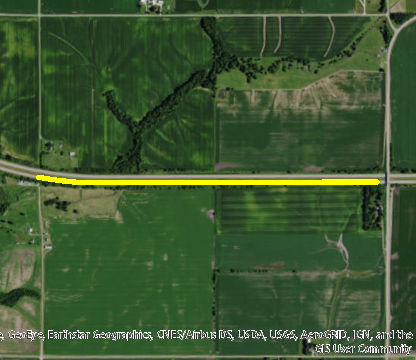

60W05


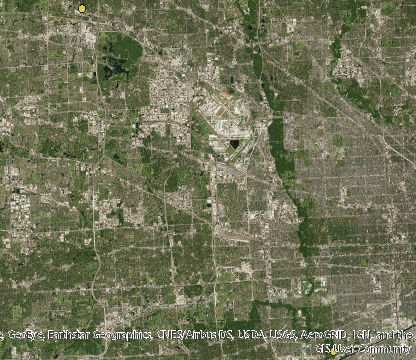

72F31


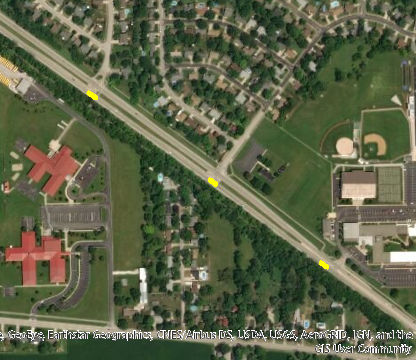

72F31


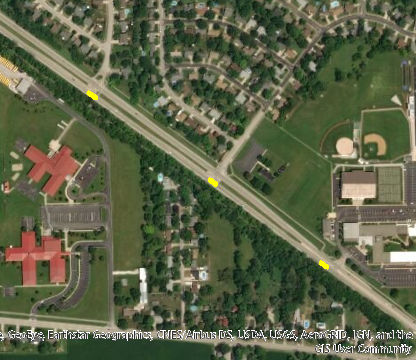

72F31


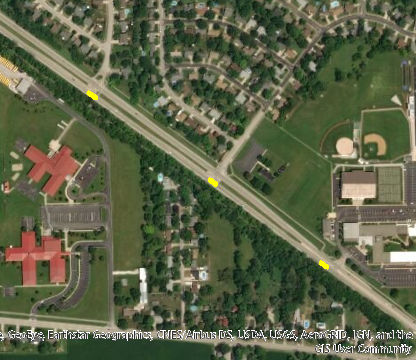

72F50


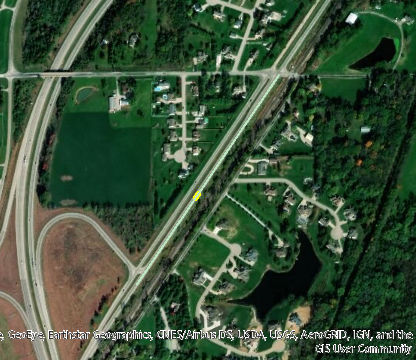

60W19


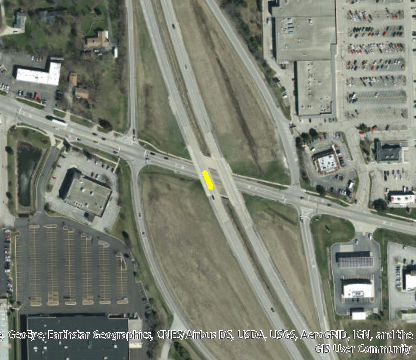

63829


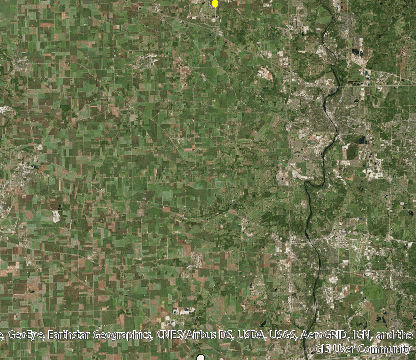

60T88


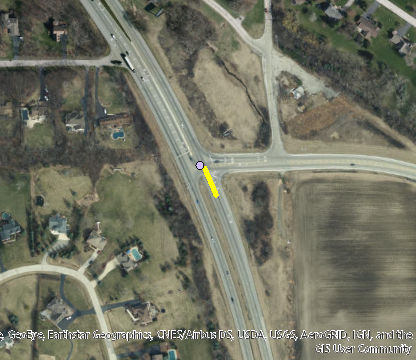

60T92


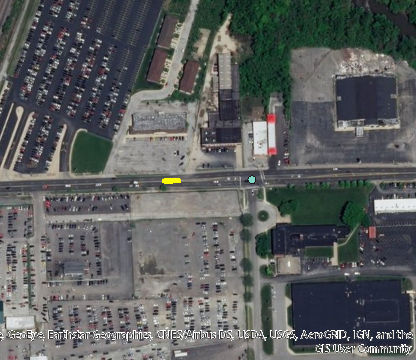

72G04


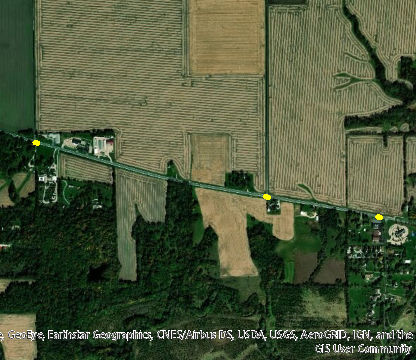

72G04


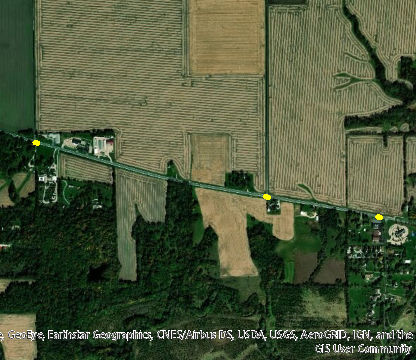

72G04


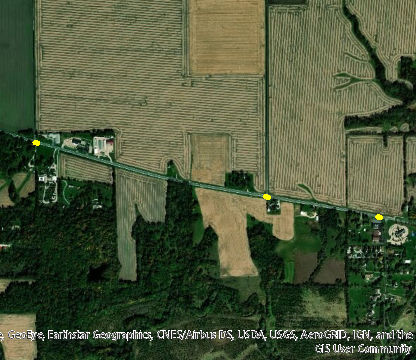

60R59


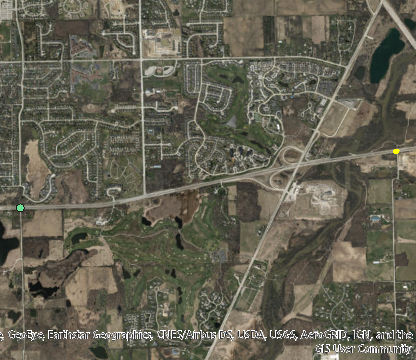

60R59


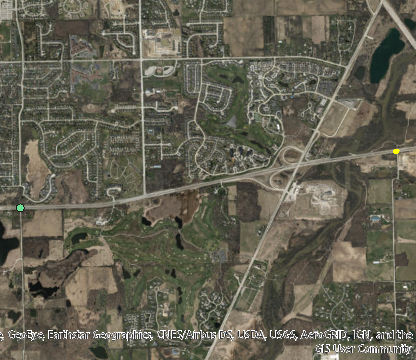

72F95


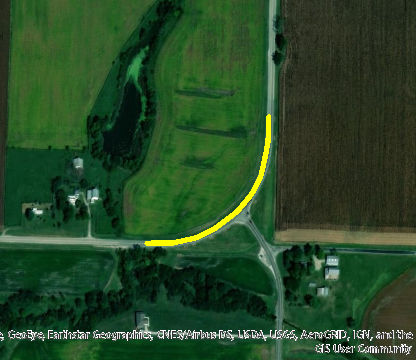

91481


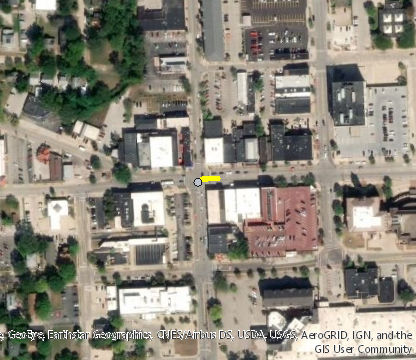

60V95


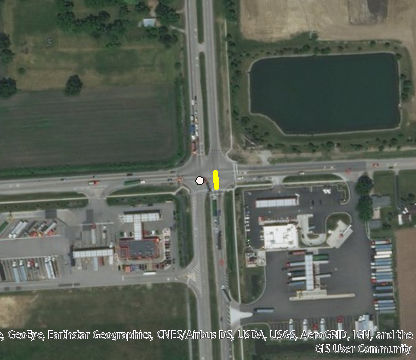

60T95


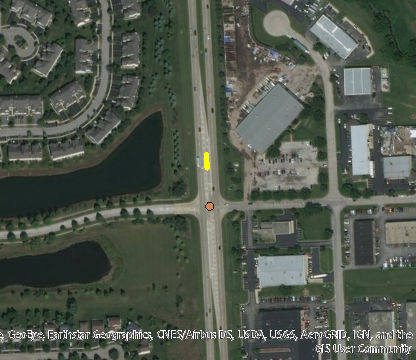

63669


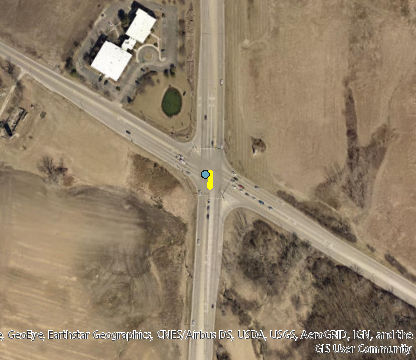

60P63


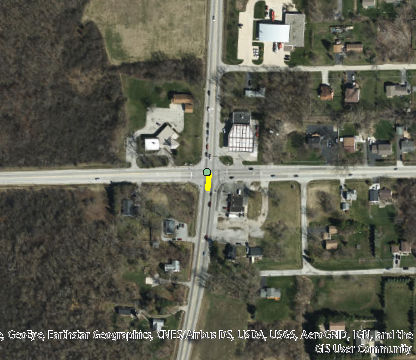

68B09


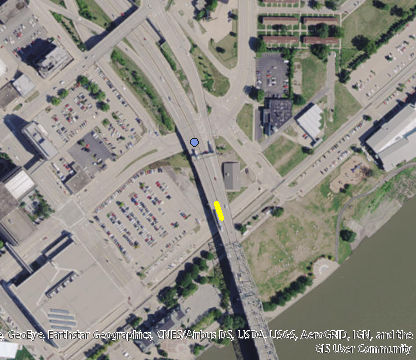

60P90


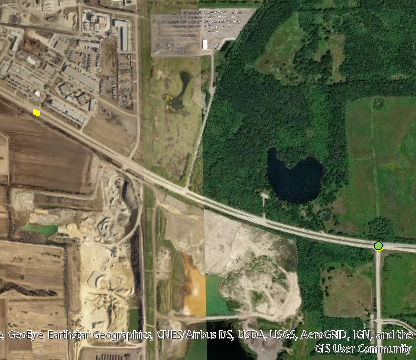

60P90


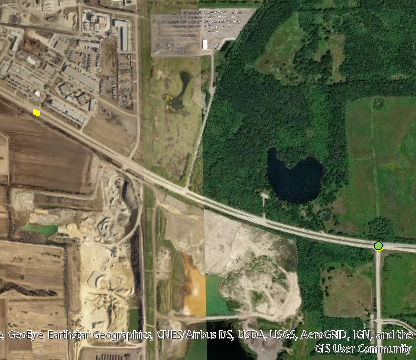

87514


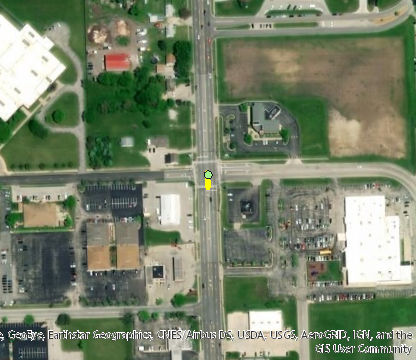

72F06


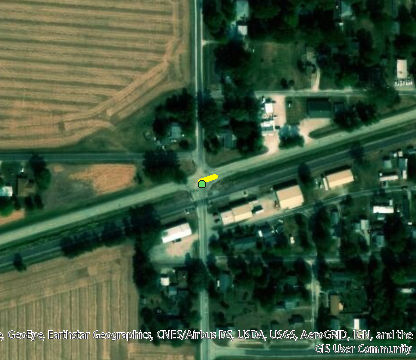

63684


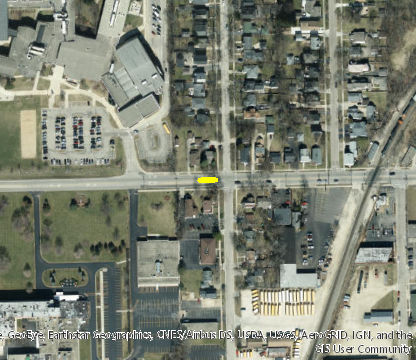

60P13


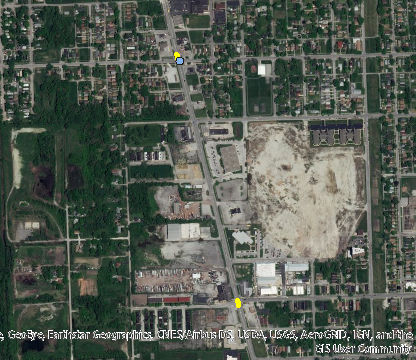

60P13


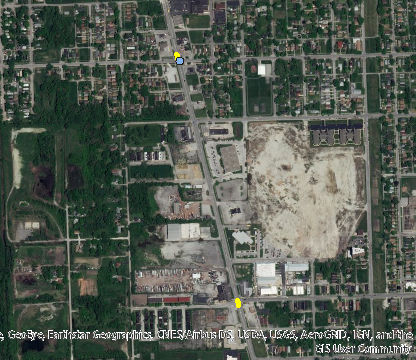

72F24


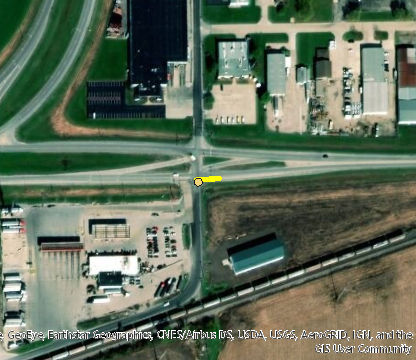

72F13


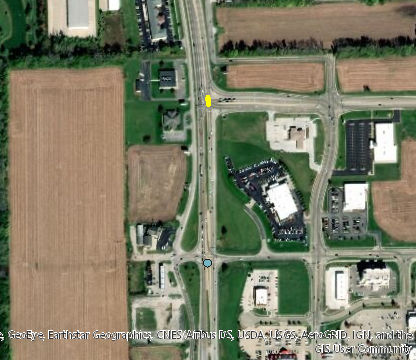

87518


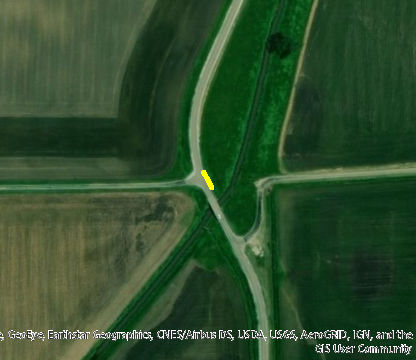

89591


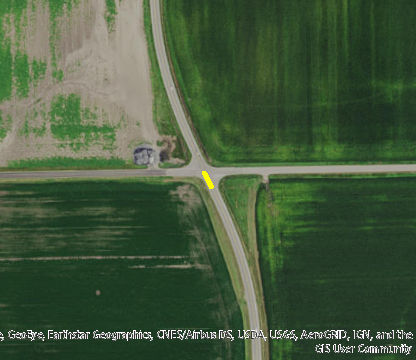

64H66


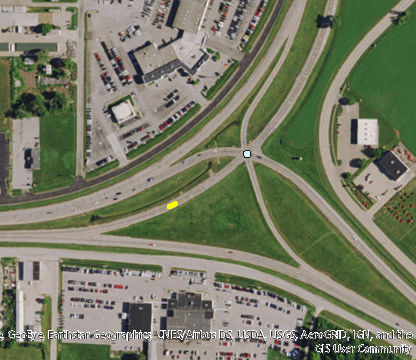

87479


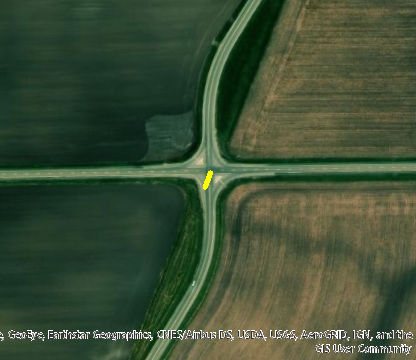

60P23


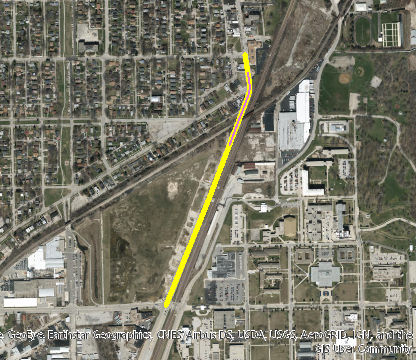

72D66


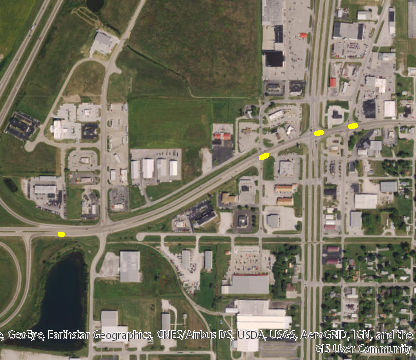

72D66


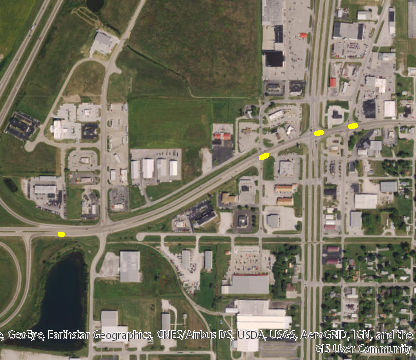

72D66


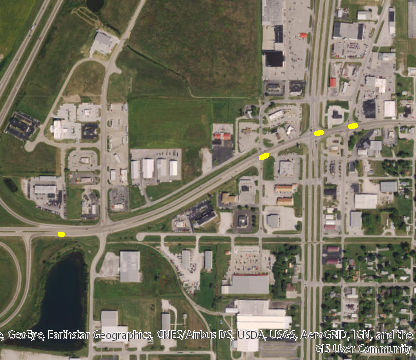

72D66


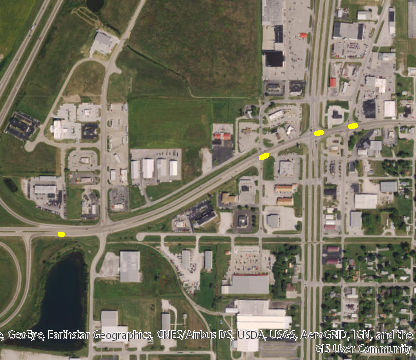

76E31


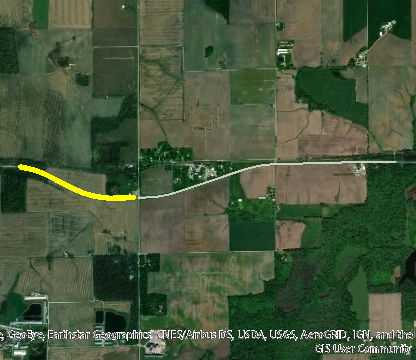

60J90


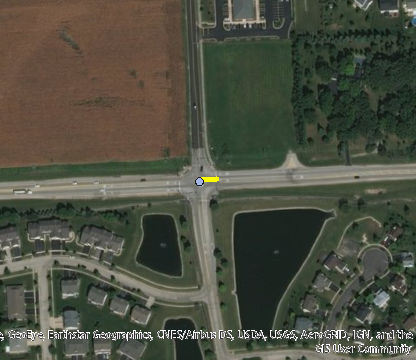

64C68


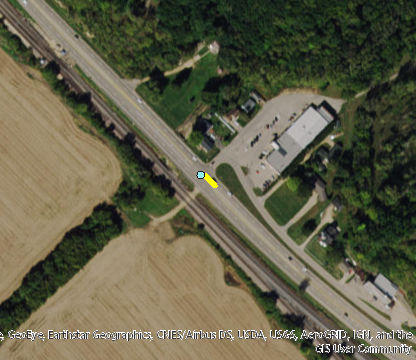

60I56


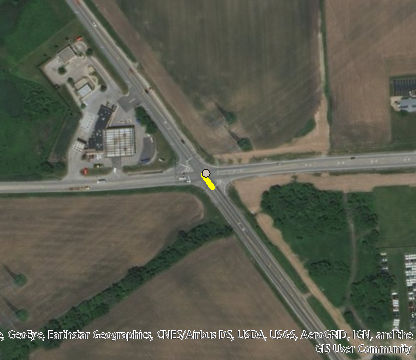

64F52


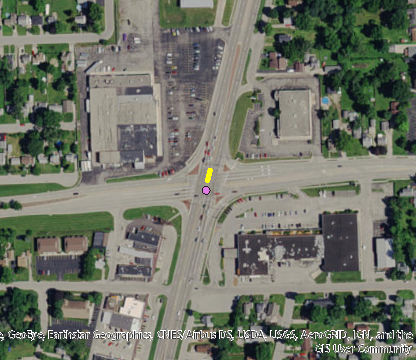

64G16


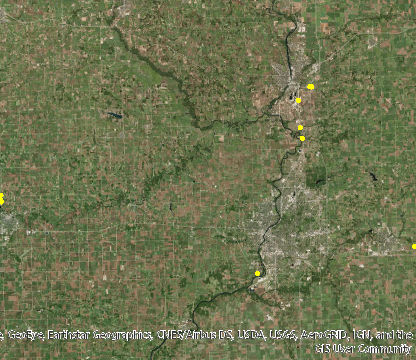

64G16


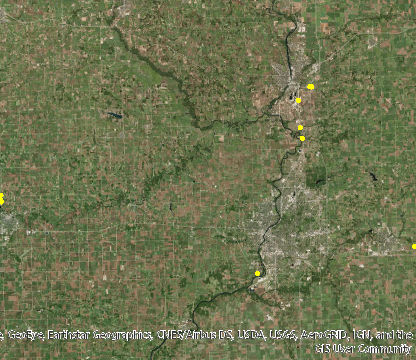

64G16


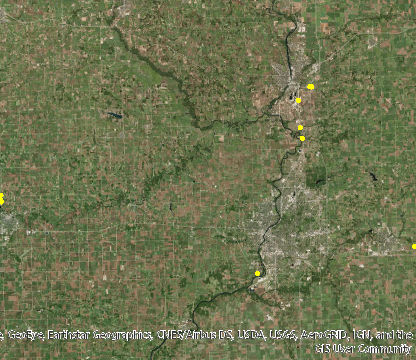

64G16


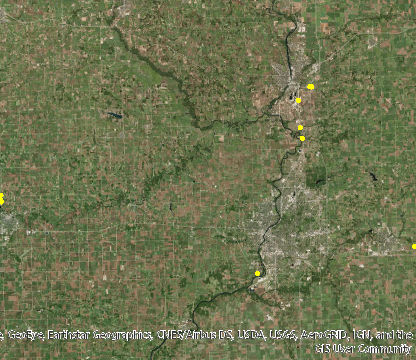

64G16


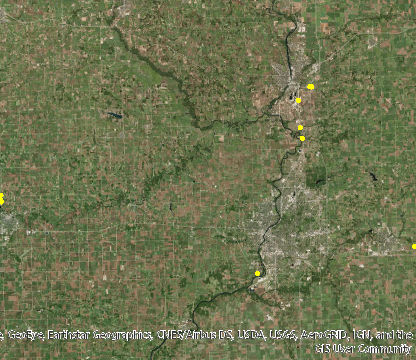

64G16


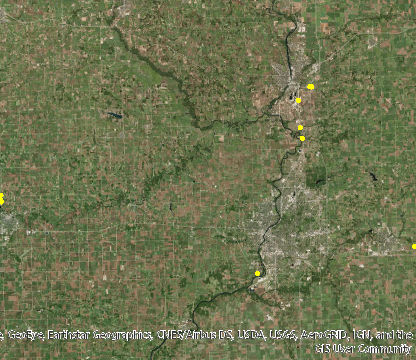

64G16


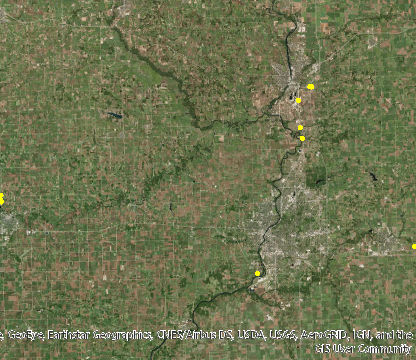

64G16


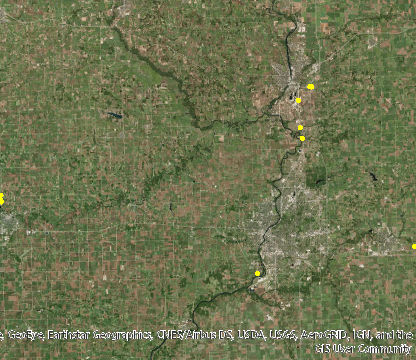

64G16


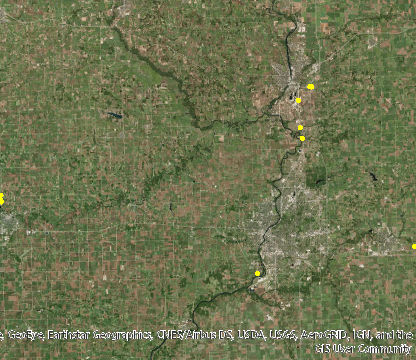

64G16


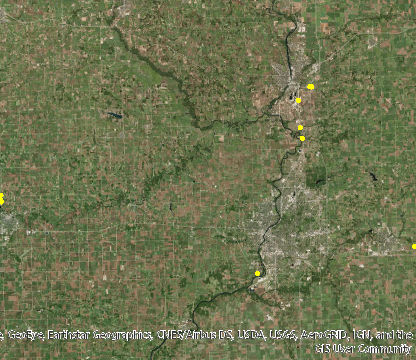

72D64


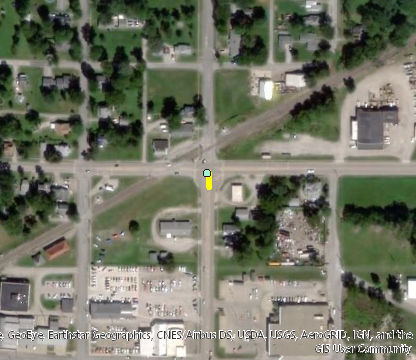

76D89


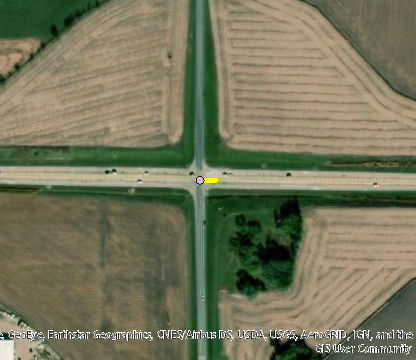

63416


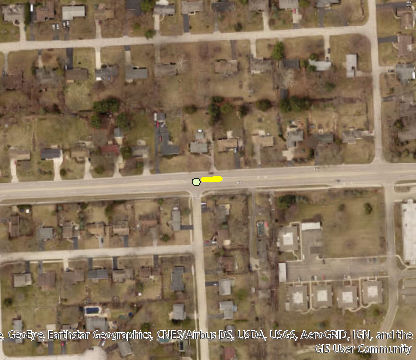

60I27


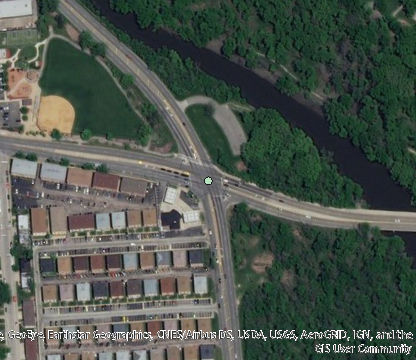

72D48


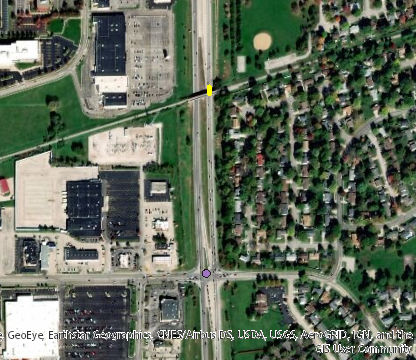

74445


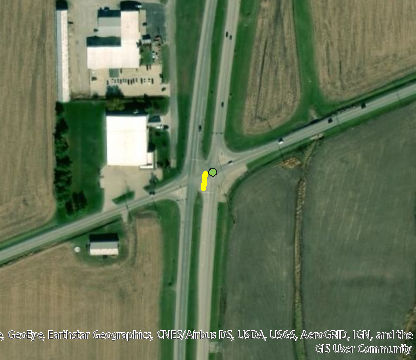

76C64


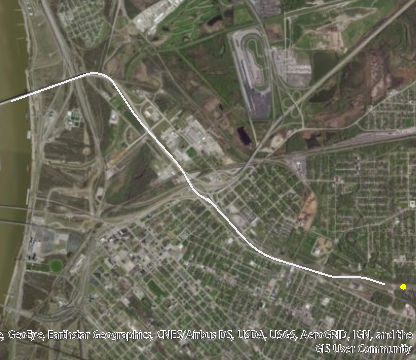

64F37


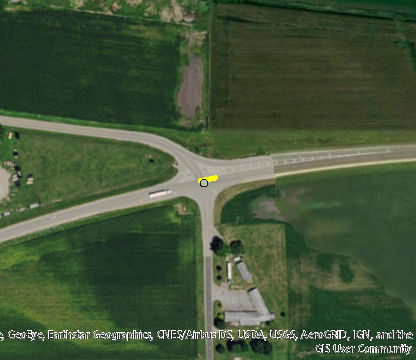

64E29


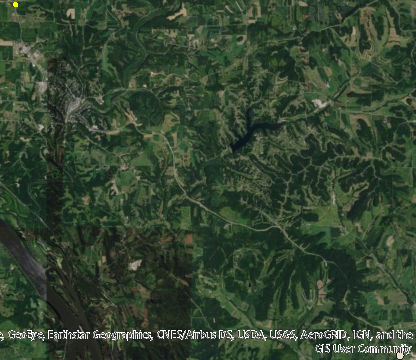

64F53


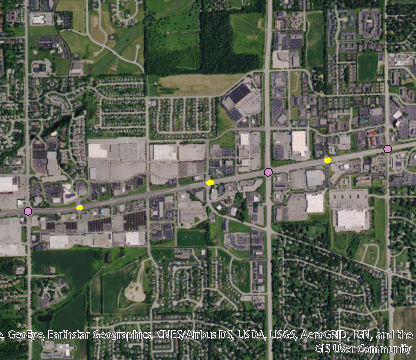

64F53


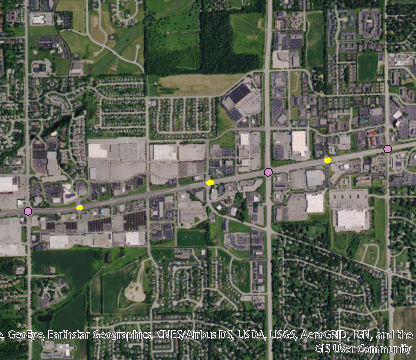

64F53


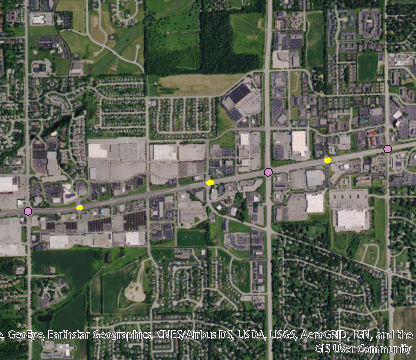

85413


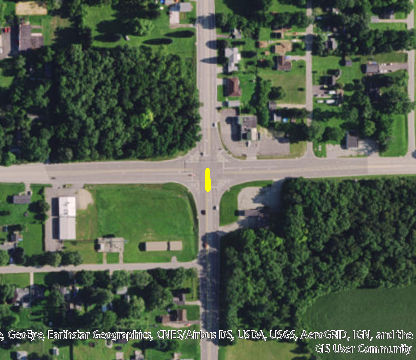

72817


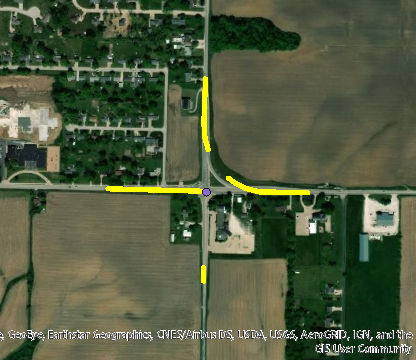

72817


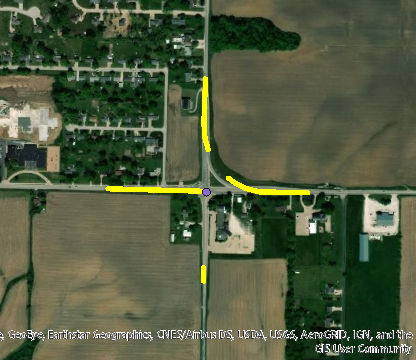

72817


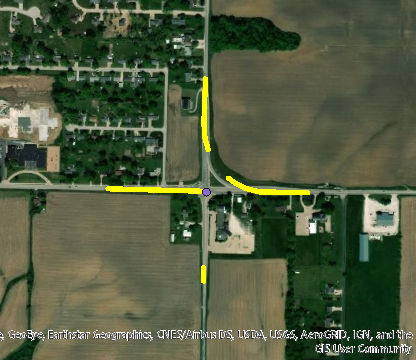

72817


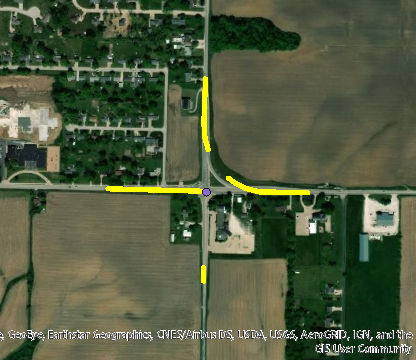

60E64


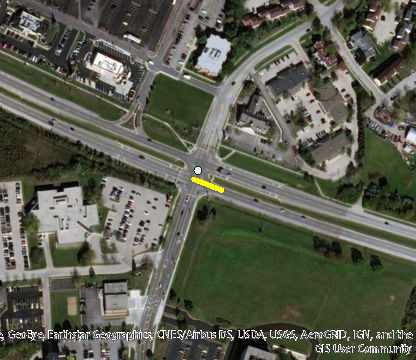

93493


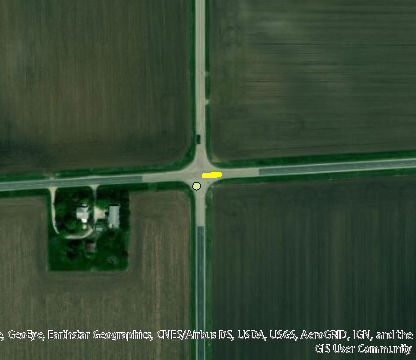

60E65


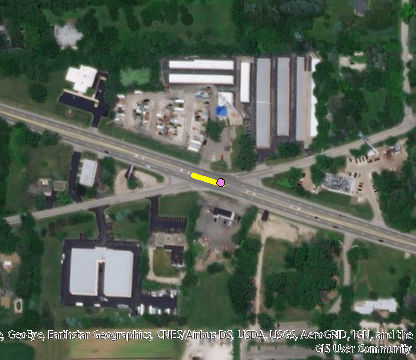

93477


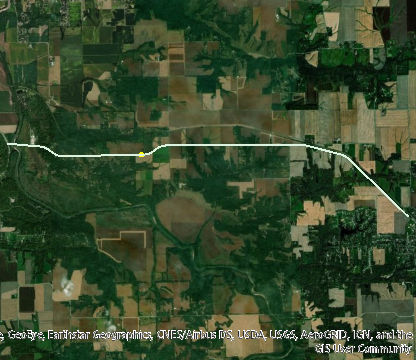

64E55


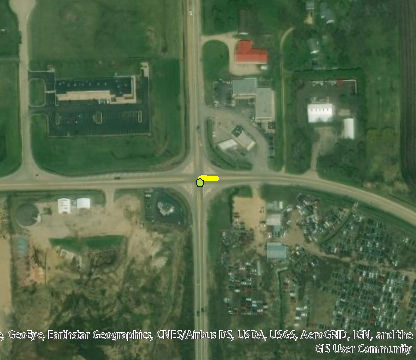

89480


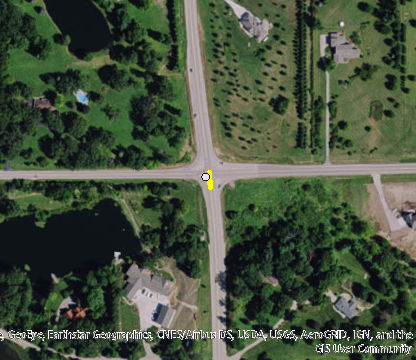

64E90


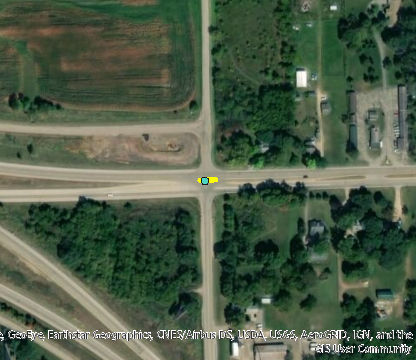

68110


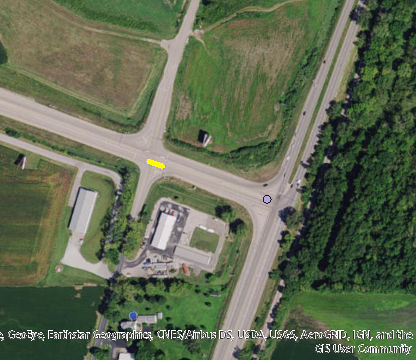

64D51


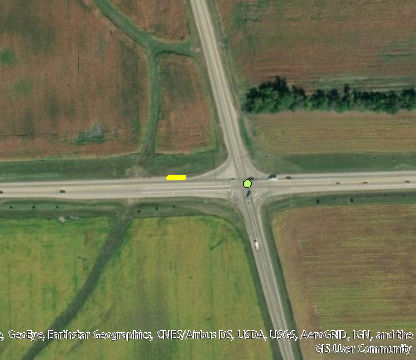

76C29


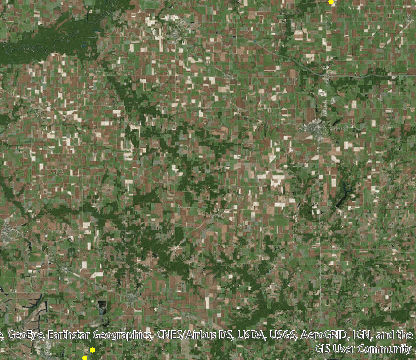

76C29


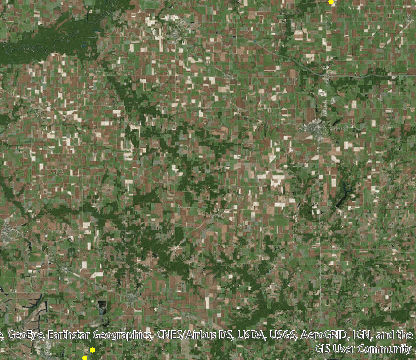

76C29


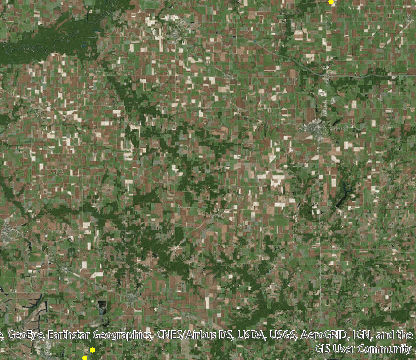

63048


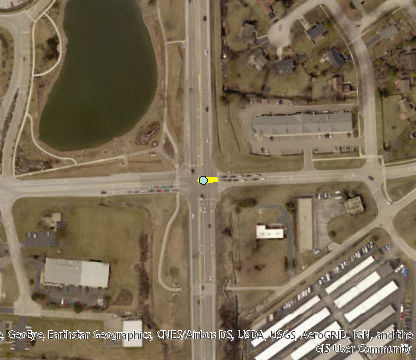

97323


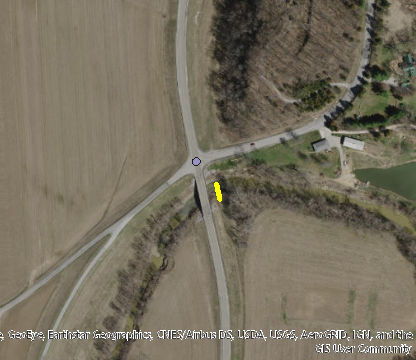

60D98


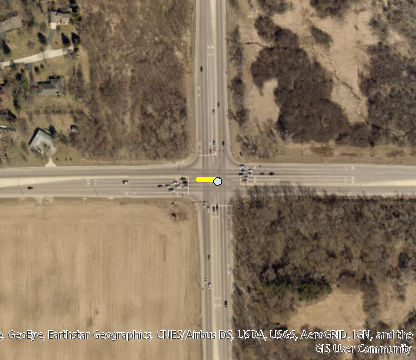

62949


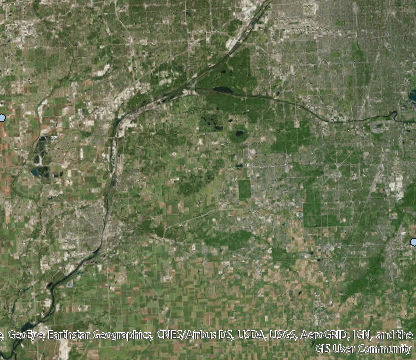

60D51


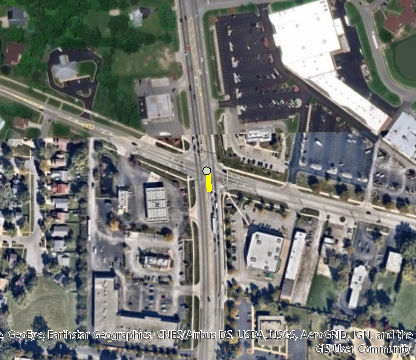

93443


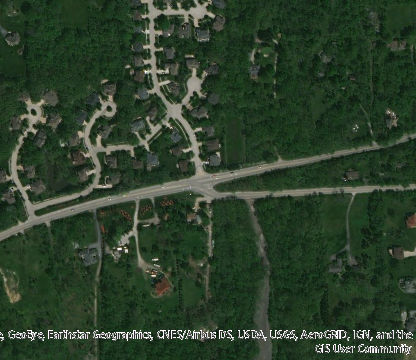

97319


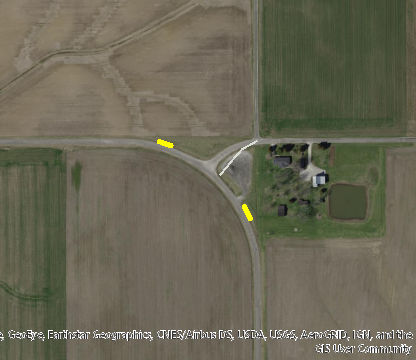

97319


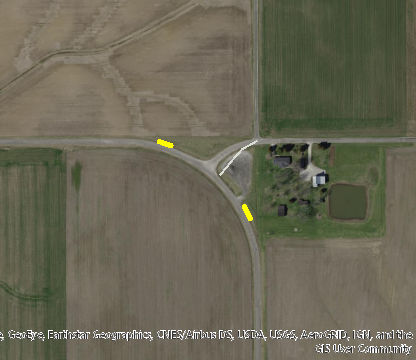

64D76


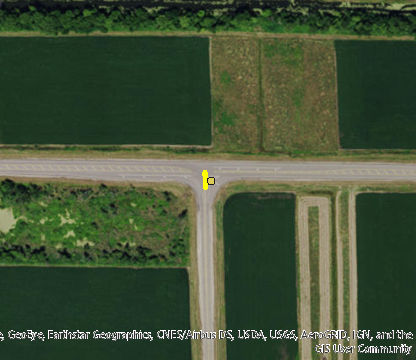

60A25


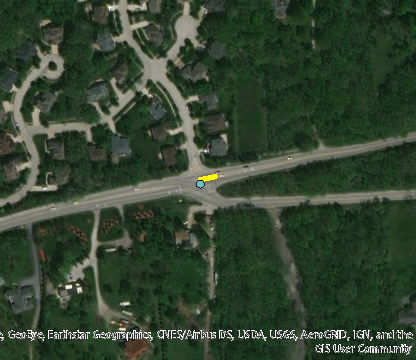

60C14


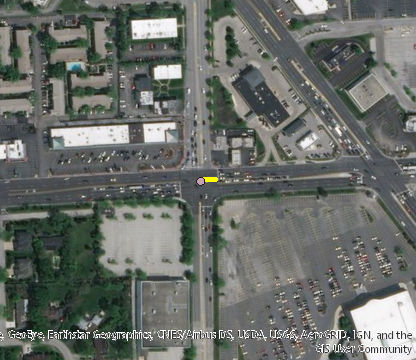

62915


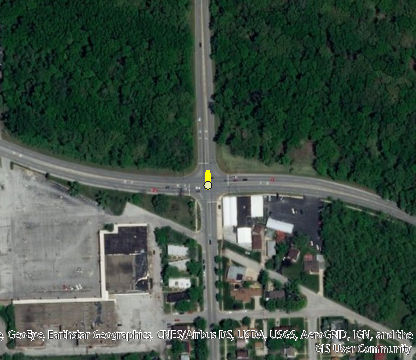

64D53


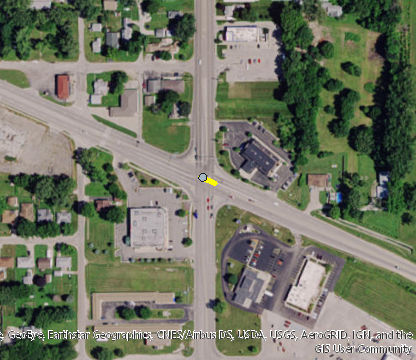

99306


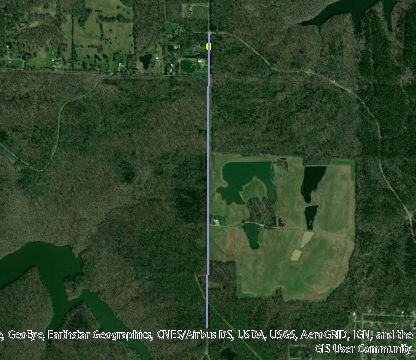

85412


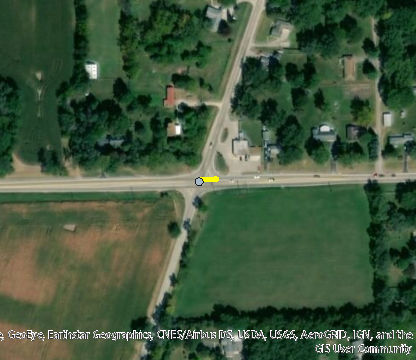

72899


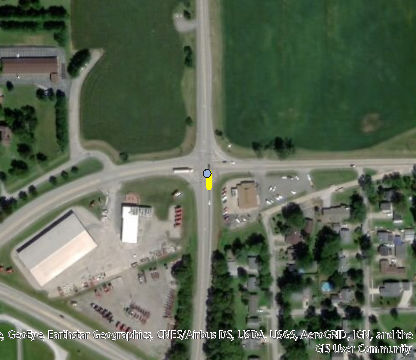

60C09


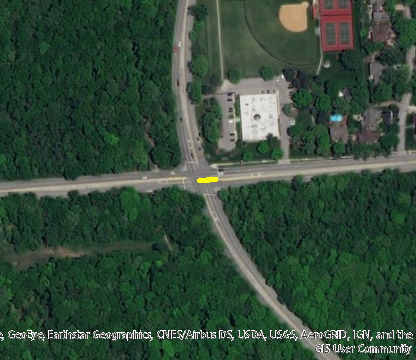

60C15


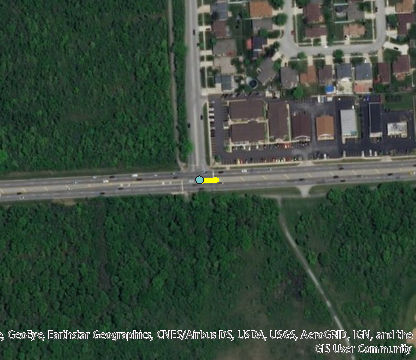

70628


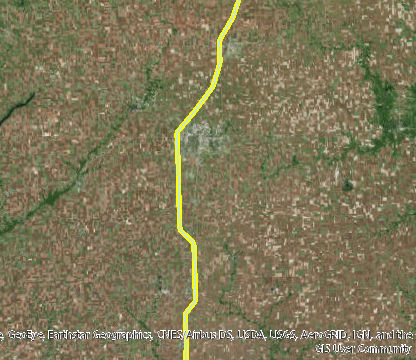

70628


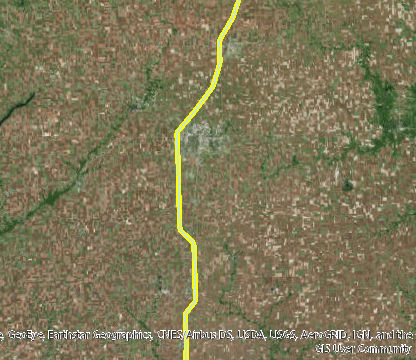

64D09


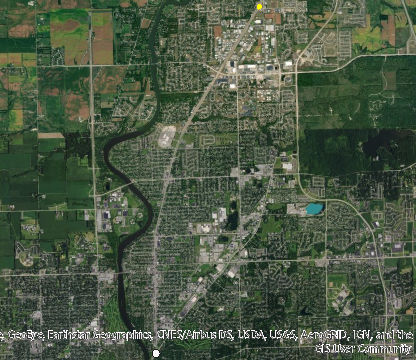

89470


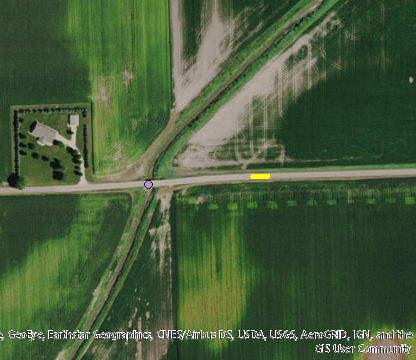

64B81


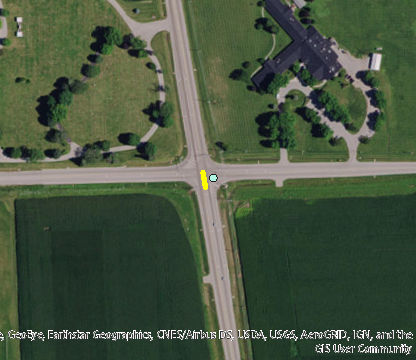

74208


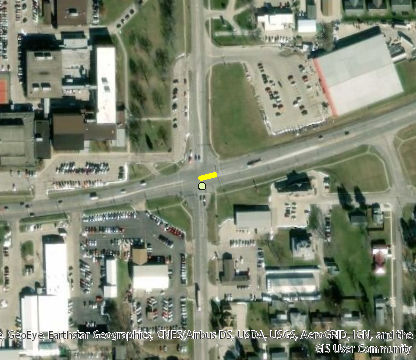

76A27


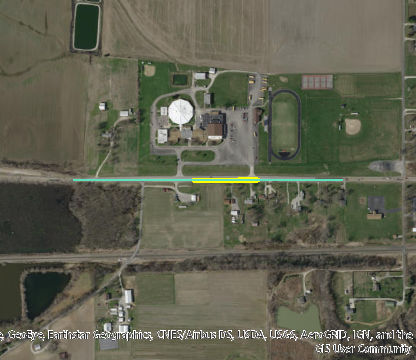

74209


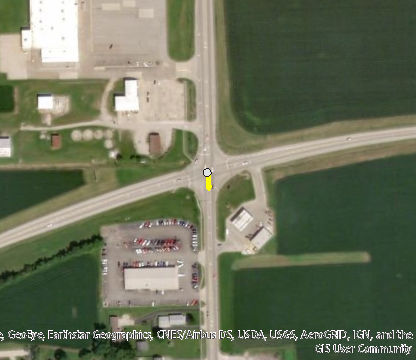

72A54


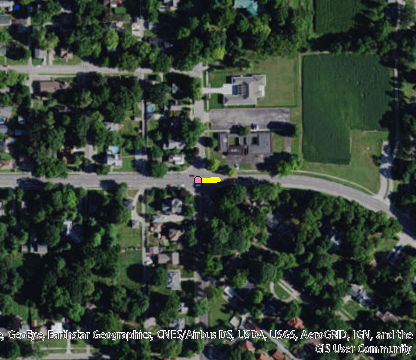

In [17]:
# Completed, w HSIP Amnt, w loc, w comp Amnt and Date, within 05-15, not evaluated
ContList = list(Cont_DF[(Cont_DF.IsCompleted=='Completed') & 
                        (Cont_DF.HasHSIPAmnt=='With HSIPAmnt') & 
                        #(Cont_DF.HasLocation=='With Loc') & 
                        (Cont_DF.HasCompAmnt=='With CmpAmnt') & 
                        (Cont_DF.HasCompDate=='With CmpDate') & 
                        (Cont_DF['Within2007-2015']=='Within 2007-2015') & 
                        (Cont_DF.Evaluated=='Not Evaluated')].ContNum)
print(len(ContList))
for c in ContList:
    fn = ContractsDir + '\\HSIP_{}_Site.jpg'.format(c)
    if os.path.exists(fn):
        print(c)
        display(Image(fn))
        

In [158]:
# Completed, w HSIP Amnt, No loc
from IPython.display import Image
ContList = list(Cont_DF[(Cont_DF.IsCompleted=='Completed') & 
                        (Cont_DF.HasHSIPAmnt=='With HSIPAmnt') & 
                        (Cont_DF['Within2007-2015']=='Within 2007-2015') & 
                        (Cont_DF.HasLocation=='No Loc')].ContNum)
print(len(ContList))
for c in ContList:
    fn = ContractsDir + '\\HSIP_{}_Site.jpg'.format(c)
    if os.path.exists(fn):
        print(c)
        display(Image(fn))
Cont_DF.loc[ContList][(Cont_DF.HSIP_Int_Count>0) | (Cont_DF.HSIP_Seg_Len>0)]       

46


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


ContNum    HSIPIDs LastLettingDate  AwardDate CompletionDate  \
60D19   60D19  201410008      2007-11-16 2007-12-06     2008-05-27   
70A00   70A00  201207002      2013-05-24 2013-06-18     2014-10-01   
72D57   72D57  201303004      2012-11-09 2012-12-05     2013-05-09   
85533   85533  201506055      2011-04-29 2011-05-19     2011-08-05   
99312   99312  201410235      2008-04-25 2008-05-21     2008-09-19   

       AwardAmount  CompletionAmount         D20       D21       D22  \
60D19    163136.46         192341.38   143965.22       0.0      0.00   
70A00   2111043.14        2077182.78  1596601.93       0.0      0.00   
72D57     24970.00          24707.50    22473.00       0.0      0.00   
85533    227894.38         227810.13        0.00  171000.0      0.00   
99312    108678.98         171030.90        0.00       0.0  97811.08   

           ...        HasLocation  IsCompleted   HasCompAmnt   HasCompDate  \
60D19      ...             No Loc    Completed  With CmpAmnt  With CmpDate   
70A00      ...             No Loc    Completed  With CmpAmnt  With CmpDate   
72D57      ...             No Loc    Completed  With CmpAmnt  With CmpDate   
85533      ...             No Loc    Completed  With CmpAmnt  With CmpDate   
99312      ...             No Loc    Completed  With CmpAmnt  With CmpDate   

        Within2007-2015 EvaluatedNaive    HasHSIPAmnt      Evaluated  \
60D19  Within 2007-2015  Not Evaluated  With HSIPAmnt  Not Evaluated   
70A00  Within 2007-2015  Not Evaluated  With HSIPAmnt  Not Evaluated   
72D57  Within 2007-2015  Not Evaluated  With HSIPAmnt  Not Evaluated   
85533  Within 2007-2015  Not Evaluated  With HSIPAmnt  Not Evaluated   
99312  Within 2007-2015  Not Evaluated  With HSIPAmnt  Not Evaluated   

      HSIP_Seg_Len HSIP_Int_Count  
60D19     0.000000              1  
70A00    15.438512              0  
72D57    36.871372              0  
85533    14.489386              0  
99312     7.512049              0  

[5 rows x 57 columns]

97
74


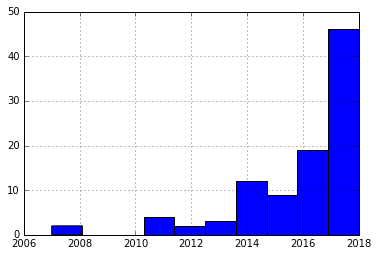

In [241]:
# Completed, w HSIP Amnt, w loc, w comp Amnt and Date, within 05-15, not evaluated
ContList = list(Cont_DF[(Cont_DF.IsCompleted=='Completed') & 
                        (Cont_DF.HasHSIPAmnt=='With HSIPAmnt') & 
                        (Cont_DF['Within2007-2015']=='Missing Compl Date') & 
                        (Cont_DF.HasLocation=='With Loc')].ContNum)
print(len(ContList))
l = list(Cont_DF.loc[ContList]['AwardDate'])
print(len([i.year for i in l if i>datetime(2015,1,1)]))
plt.hist([i.year for i in l if i>datetime(2000,1,1)])
plt.grid()
plt.show()


45
41


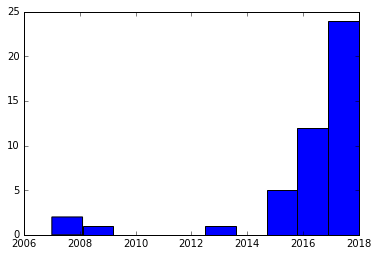

In [185]:
# Completed, w HSIP Amnt, w loc, w comp Amnt and Date, within 05-15, not evaluated
ContList = list(Cont_DF[(Cont_DF.IsCompleted=='Completed') & 
                        (Cont_DF.HasHSIPAmnt=='With HSIPAmnt') & 
                        (Cont_DF['Within2007-2015']=='Missing Compl Date') & 
                        (Cont_DF.HasLocation=='No Loc')].ContNum)
print(len(ContList))
l = list(Cont_DF.loc[ContList]['AwardDate'])
print(len([i.year for i in l if i>datetime(2015,1,1)]))
plt.hist([i.year for i in l if i>datetime(2000,1,1)])
plt.show()


In [246]:
# Completed, w HSIP Amnt, w loc, w comp Amnt and Date, within 05-15, not evaluated
ContList = list(Cont_DF[(Cont_DF.IsCompleted=='Completed') & 
                        (Cont_DF.HasHSIPAmnt=='With HSIPAmnt') & 
                        (Cont_DF['Within2007-2015']=='Missing Award and Compl Dates') & 
                        (Cont_DF.HasLocation=='With Loc')].ContNum)
print(len(ContList))
#Cont_DF.loc[ContList][(Cont_DF.HSIP_AwardDate>datetime(2007,1,1)) & (Cont_DF.HSIP_CompDate<datetime(2015,1,1)) & (Cont_DF.NumOfJoinedConts==1)]
display(Cont_DF.loc[ContList][(Cont_DF.HSIP_AwardDate>datetime(2007,1,1)) & (Cont_DF.HSIP_CompDate<datetime(2015,1,1))])

ContList = list(Cont_DF[(Cont_DF.IsCompleted=='Completed') & 
                        (Cont_DF.HasHSIPAmnt=='With HSIPAmnt') & 
                        (Cont_DF['Within2007-2015']=='Missing Award and Compl Dates') & 
                        (Cont_DF.HasLocation=='No Loc')].ContNum)
print(len(ContList))
#Cont_DF.loc[ContList][(Cont_DF.HSIP_AwardDate>datetime(2007,1,1)) & (Cont_DF.HSIP_CompDate<datetime(2015,1,1)) & (Cont_DF.NumOfJoinedConts==1)]
Cont_DF.loc[ContList][(Cont_DF.HSIP_AwardDate>datetime(2007,1,1)) & (Cont_DF.HSIP_CompDate<datetime(2015,1,1)) & ((Cont_DF.HSIP_Seg_Len>0) | (Cont_DF.HSIP_Int_Count>0))]

66


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


ContNum              HSIPIDs LastLettingDate AwardDate CompletionDate  \
60D36   60D36            201410002      2008-06-13       NaT            NaT   
60D52   60D52            201407010      2008-03-07       NaT            NaT   
60K09   60K09            201410020      2011-09-23       NaT            NaT   
60K65   60K65            201410049      2011-06-17       NaT            NaT   
60L22   60L22  201203014;201410054      2011-11-18       NaT            NaT   
60L25   60L25            201410053      2011-11-18       NaT            NaT   
60X59   60X59            201203010      2018-01-19       NaT            NaT   
62843   62843            201407013      2007-06-15       NaT            NaT   
64E34   64E34            201410320      2010-09-17       NaT            NaT   
66685   66685            201410096      2007-04-27       NaT            NaT   
66720   66720            201410098      2008-09-19       NaT            NaT   
66739   66739            201410097      2008-03-07       NaT            NaT   
66983   66983            201410323      2011-09-23       NaT            NaT   
70592   70592  201403001;201410138      2010-11-05       NaT            NaT   
72D19   72D19            201410351      2010-04-23       NaT            NaT   
74300   74300            201410194      2009-09-18       NaT            NaT   
74425   74425            201410364      2010-03-05       NaT            NaT   
74427   74427            201410363      2010-04-23       NaT            NaT   
74552   74552            201410372      2013-03-08       NaT            NaT   
76B22   76B22            201410208      2008-08-01       NaT            NaT   
93468   93468            201410166      2008-09-19       NaT            NaT   

       AwardAmount  CompletionAmount         D20  D21        D22  ...    \
60D36    191977.10         182605.00   172779.39  0.0       0.00  ...     
60D52    761115.79         836947.44   680945.21  0.0       0.00  ...     
60K09   4425434.89        4757546.66  3747500.17  0.0       0.00  ...     
60K65   1258968.28        1229159.09   993855.26  0.0       0.00  ...     
60L22    501317.20         527885.98   414560.88  0.0       0.00  ...     
60L25   1195993.87        1165717.23  1073232.78  0.0       0.00  ...     
60X59    774314.63              0.00   647186.07  0.0       0.00  ...     
62843   1931519.87        1918732.40  1666341.85  0.0       0.00  ...     
64E34   1386167.12        1594627.09  1247404.40  0.0       0.00  ...     
66685    533796.24         536469.94   480416.62  0.0       0.00  ...     
66720   2314963.49        2193533.76  1406096.11  0.0       0.00  ...     
66739    470939.50         455758.75   423845.55  0.0       0.00  ...     
66983   1929222.94        1866215.66   781462.28  0.0       0.00  ...     
70592   2037020.24        2066659.24  1833318.21  0.0       0.00  ...     
72D19     86946.15          82560.17    78251.54  0.0       0.00  ...     
74300    217104.37         217984.13   195393.93  0.0       0.00  ...     
74425    165472.00         163094.00   148924.80  0.0       0.00  ...     
74427    428753.53         428586.58   385878.18  0.0       0.00  ...     
74552   3272592.29        3252556.73  2204977.64  0.0       0.00  ...     
76B22   1171623.94        1190367.85   963003.97  0.0       0.00  ...     
93468    405671.05         413233.41        0.00  0.0  375775.94  ...     

       HSIP_AwardDate Length Length Length HSIP_CompDate Length Length Length  \
60D36      2008-07-15  11.05  11.05  11.05    2008-09-17  11.05  11.05  11.05   
60D52      2008-04-03   0.22   0.22   0.22    2009-04-18   0.22   0.22   0.22   
60K09      2012-01-18   0.01   0.01   0.01    2013-07-15   0.01   0.01   0.01   
60K65      2011-08-22   0.10   0.10   0.10    2012-10-11   0.10   0.10   0.10   
60L22      2011-12-13   0.01   0.01   0.01    2012-06-29   0.01   0.01   0.01   
60L25      2011-12-13   0.25   0.25   0.25    2012-08-03   0.25   0.25   0.25   
60X59      2012-02-01   0.10   0.10   0.10    201

5


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


ContNum    HSIPIDs LastLettingDate AwardDate CompletionDate  \
63122   63122  201506066      2009-06-12       NaT            NaT   

       AwardAmount  CompletionAmount  D20       D21  D22  ...    \
63122     535088.2         500403.12  0.0  260699.0  0.0  ...     

       HSIP_AwardDate Length Length Length HSIP_CompDate Length Length Length  \
63122      2009-07-24    NaN    NaN    NaN    2009-10-16    NaN    NaN    NaN   

      Length Length  
63122    NaN    NaN  

[1 rows x 73 columns]

In [250]:
ContList = list(Cont_DF[(Cont_DF.IsCompleted=='Completed') & 
                        (Cont_DF.HasHSIPAmnt=='With HSIPAmnt') & 
                        (Cont_DF['Within2007-2015']=='Missing Award Date') & 
                        (Cont_DF.HasLocation=='With Loc')].ContNum)
print(len(ContList))
display(Cont_DF.loc[ContList][(Cont_DF.HSIP_AwardDate>datetime(2007,1,1)) & (Cont_DF.HSIP_CompDate<datetime(2015,1,1))])

ContList = list(Cont_DF[(Cont_DF.IsCompleted=='Completed') & 
                        (Cont_DF.HasHSIPAmnt=='With HSIPAmnt') & 
                        (Cont_DF['Within2007-2015']=='Missing Award Date') & 
                        (Cont_DF.HasLocation=='No Loc')].ContNum)
print(len(ContList))
display(Cont_DF.loc[ContList][(Cont_DF.HSIP_AwardDate>datetime(2007,1,1)) & (Cont_DF.HSIP_CompDate<datetime(2015,1,1)) & ((Cont_DF.HSIP_Seg_Len>0) | (Cont_DF.HSIP_Int_Count>0))])

4


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


ContNum    HSIPIDs LastLettingDate AwardDate CompletionDate  \
76D36   76D36  201410379      2010-07-30       NaT     2013-08-29   

       AwardAmount  CompletionAmount       D20  D21  D22  ...    \
76D36   2497000.43        2640613.99  47176.88  0.0  0.0  ...     

       HSIP_AwardDate Length Length Length HSIP_CompDate Length Length Length  \
76D36      2010-08-20    0.3    0.3    0.3    2013-08-29    0.3    0.3    0.3   

      Length Length  
76D36    0.3    0.3  

[1 rows x 73 columns]

1


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


Empty DataFrame
Columns: [ContNum, HSIPIDs, LastLettingDate, AwardDate, CompletionDate, AwardAmount, CompletionAmount, D20, D21, D22, D15, D10, D28, Status, Impr_WPPS, District, EA, IsSystemic, Imp_HSIP, CostCat, FundSource, Duration, BeforePeriod, AfterPeriod, ConstPeriod, B_K_OC, B_K_EC, B_A_OC, B_A_EC, B_B_OC, B_B_EC, A_K_OC, A_K_EC, A_A_OC, A_A_EC, A_B_OC, A_B_EC, EUAC, EUAB_OC, EUAB_EC, BC_OC, BC_EC, NumOfHSIP, Joined_Conts, HSIPAmount, NumOfJoinedConts, Length, HasLocation, IsCompleted, HasCompAmnt, HasCompDate, Within2007-2015, EvaluatedNaive, HasHSIPAmnt, Evaluated, HSIP_Seg_Len, HSIP_Int_Count, Awarded_Within_07-15, Comp_Within_07-15, Is1to1, Length, Length, Length, HSIP_AwardDate, Length, Length, Length, HSIP_CompDate, Length, Length, Length, Length, Length]
Index: []

[0 rows x 73 columns]

In [262]:
Cont_DF['Diff_AwardDate'] = Cont_DF.AwardDate-Cont_DF.HSIP_AwardDate
Cont_DF.sort_values('Diff_AwardDate')[~pd.isnull(Cont_DF.Diff_AwardDate) & Cont_DF.Diff_AwardDate!=0][['HSIPIDs','AwardDate','CompletionDate','HSIP_AwardDate','HSIP_CompDate','Diff_AwardDate']]

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


HSIPIDs  AwardDate CompletionDate HSIP_AwardDate  \
70956            201207002 2012-04-02     2012-10-30     2013-06-18   
72G93            201409002 2014-07-01     2015-04-08     2015-07-01   
91481            201505022 2013-05-22     2013-11-01     2014-05-22   
93463            201410167 2008-07-31     2008-09-24     2009-05-13   
70968  201207002;201302006 2012-12-05     2013-11-12     2013-06-18   
76994            201410203 2007-06-01     2007-11-02     2007-11-02   
70966            201302006 2012-07-13     2013-09-19     2012-12-05   
91445  201505011;201506037 2011-02-10     2012-01-16     2011-02-20   
68A27            201505008 2011-05-18     2011-08-13     2011-05-17   
63777            201507006 2013-07-18     2014-09-23     2013-07-08   
63416            201506069 2010-04-19     2010-09-17     2010-04-09   
68590            201410123 2010-07-26     2011-08-03     2010-07-06   
60I27            201410251 2010-02-11     2010-08-30     2010-01-11   
76C64            201410374 2010-02-11     2010-08-13     2010-01-11   
60X30            201309001 2014-02-24     2014-06-26     2013-08-29   
60X31            201309001 2014-02-24     2014-07-03     2013-08-29   
63718            201507001 2012-08-22     2013-03-11     2012-02-09   
74610            201410372 2014-06-03     2014-09-05     2013-04-02   
72H33            201307001 2015-05-27            NaT     2014-03-05   
99312            201410235 2008-05-21     2008-09-19     2007-02-14   
76E53            201410376 2011-02-10     2014-06-20     2009-07-23   
61C89            201310027 2016-10-03            NaT     2014-10-22   
62D44            201504002 2017-07-17            NaT     2015-03-27   
74816            201303011 2018-04-03            NaT     2015-07-08   
60V42            201405005 2017-03-20            NaT     2014-02-26   
93609            201505034 2014-05-30     2014-12-02     2009-05-13   
60Y79            201203014 2017-08-30            NaT     2011-12-13   
62B60            201203013 2017-05-23            NaT     2008-02-15   
62A47            201203016 2017-02-08            NaT     2007-07-30   

      HSIP_CompDate Diff_AwardDate  
70956           NaT      -442 days  
72G93           NaT      -365 days  
91481    2013-11-01      -365 days  
93463    2009-12-06      -286 days  
70968           NaT      -195 days  
76994    2007-11-02      -154 days  
70966           NaT      -145 days  
91445    2012-01-16       -10 days  
68A27    2011-08-13         1 days  
63777    2013-11-20        10 days  
63416    2010-09-17        10 days  
68590    2011-08-03        20 days  
60I27    2010-08-30        31 days  
76C64    2010-08-13        31 days  
60X30           NaT       179 days  
60X31           NaT       179 days  
63718    2012-08-14       195 days  
74610    2013-08-08       427 days  
72H33           NaT       448 days  
99312    2007-08-03       462 days  
76E53    2009-11-14       567 days  
61C89           NaT       712 days  
62D44           NaT       843 days  
74816           NaT      1000 days  
60V42           NaT      1118 days  
93609    2009-12-06      1843 days  
60Y79           NaT      2087 days  
62B60           NaT      3385 days  
62A47           NaT      3481 days